In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("Traffic.ipynb")

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import csv
import json
import os
import contextily as cx
from collections import defaultdict
import re
from typing import Callable

from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

from zipfile import ZipFile
zf = ZipFile('data.zip', 'r')
zf.extractall('.')

# more readable exceptions
%pip install --quiet iwut
%load_ext iwut
%wut on

Note: you may need to restart the kernel to use updated packages.


# Step 1 - Guided Data Cleaning: Partitioning Data Spatially

Our hope is answer: How do we group information spatially? We'll specifically look at 2 ways of partitioning data spatially, to understand the impact of spatial partitioning strategies on our analyses:

1. Dividing the world uniformly into slices, like Google's plus codes.
2. Dividing the world according to population, using census tracts.

In this step, we'll load the following datasets that we'll need for this project:

- Daily travel times from Uber Movement data in March 2020 from San Francisco, by census tract
- Daily traffic speeds from Uber Movement data in Q1 2020 from San Francisco, between OSM nodes
- Census tracts dividing San Francisco by GPS coordinates
- Mapping from OSM nodes to GPS coordinates

There are several terms and concepts to get familiar with upfront:

- **Open Street Maps (OSM)** provides nodes (points in space, [wiki](https://wiki.openstreetmap.org/wiki/Node)) and ways (segments between nodes [wiki](https://wiki.openstreetmap.org/wiki/Way)). These IDs are used in the Uber Movement dataset to identify streets in the traffic speeds dataset.
- **Census Tracts** provided by the county of San Francisco geographically divides space according to the US 2010 Census. This is used in the Uber Movement dataset to identify regions of differing travel times.

## 1.a. Load Uber traffic speeds dataset

The dataset is located at `data/movement-speeds-daily-san-francisco-2020-3.csv`. **Load this dataset into a dataframe.**

*The original dataset from Uber was provided hourly and took up 2.1 GB on disk, which means it couldn't fit into your 1GB of RAM. You can find the dataset preparation script at `data/PrepareTrafficDataset.ipynb` which aggregated within each day, reducing the dataset to just 55MB on disk.*

*This was originally going to be question in this project, but it takes 22 minutes to run. Better yet, if you mess up, your kernel dies and you start over. We deemed it too frustrating and preprocessed the dataset to spare you the pain... but just know that this is a real-world issue!*

<!--
BEGIN QUESTION
name: q1a
points: 1
-->

In [3]:
# Load Uber Movement (Movement Speeds) dataset into dataframe
speeds_to_nodes = pd.read_csv('data/movement-speeds-daily-san-francisco-2020-3.csv')

speeds_to_nodes

osm_start_node_id  osm_end_node_id  day  speed_mph_mean
0                   281266        702258940    1       59.674042
1                   281266        702274215    1       68.444042
2                   302876        240259516    1       66.446500
3                   302878        437325360    1       65.516850
4                   302883         65381191    1       61.880556
...                    ...              ...  ...             ...
1586647         6569140748       1350115374   31       68.484833
1586648         6570476556       4551993266   31       36.837000
1586649         6573249373       4911384010   31       39.021000
1586650         6573553681        256888796   31       68.728333
1586651         6577722252        209835741   31       68.905538

[1586652 rows x 4 columns]

In [4]:
grader.check("q1a")

q1a results: All test cases passed!

<!-- BEGIN QUESTION -->

## 1.b. Map traffic speed to Google Plus Codes

Google Plus Codes divide up the world uniformly into rectangular slices ([link](https://maps.google.com/pluscodes/)). Let's use this to segment traffic speeds spatially. Take a moment to answer: **Is this spatial structure effective for summarizing traffic speed?** Before completing this section, substantiate your answer with examples of your expectations (e.g., we expect A to be separated from B). After completing this section, substantiate your answer with observations you've made.

<!--
BEGIN QUESTION
name: q1b
points: 2
manual: True
-->

1. A rectagular spatial structure might not be the best for summarizing traffic speeds because it doesn't translate well to how roads are laid out. Some regions might capture different areas or types of roads within a city (such as a highway vs. a city road), which would cause higher variance within the slice.

- Post completion: Our expectations were in line with what we saw from the data, as the rectangular grids didn't divide the area well with respect to average speed. We suspect that this could be in part because of our observation with the rectangular grids capturing different road types.

<!-- END QUESTION -->



### 1.b.i. Load Node-to-GPS-Coordinate Data

In this substep, we'll load a mapping from OSM nodes to GPS coordinates. The dataset is provided in a gzip'ed XML file from OpenStreetMaps (OSM). The mapping from OSM nodes to GPS coordinates was downloaded from https://download.bbbike.org/osm/bbbike/SanFrancisco/SanFrancisco.osm.gz. We've downloaded this for you, to avoid any issues with OSM updates.

**If** you try to load the provided `.osm` (an `.xml` in disguise) using Python's built-in XML utilities **(by uncommenting the last 2 lines in the below cell)**, you will hit an out-of-memory error, as your kernel is forced to restart.

In [5]:
# [OSM] - Read the OSM XML and extract mapping from node ID to GPS coordinates
PATH_OSM = os.path.expanduser('data/SanFrancisco.osm')

# Runs out of memory! File itself is 430 MB, even when filtering out
# irrelevant rows, and remaining 3M rows are too expensive to parse,
# resulting in OOM

# import xml.etree.ElementTree as ET
# _tree = ET.parse(PATH_OSM)

Your above code hits a memory error, so instead, we will use our handy-dandy tool--regex--from earlier in the semester to load just the parts of the file that we need. **Given the XML snippet below, write a regex pattern to extract OSM node ID, latitude, and longitude.** (The first capture group should be node ID. The second should be latitude, and the third should be longitude.) A snippet of the XML is included below ([screenshot](https://extract.bbbike.org/extract-screenshots.html)):

```
<?xml version='1.0' encoding='UTF-8'?>
<osm version="0.6" generator="osmconvert 0.8.3">
    <bounds minlat="42.4543" minlon="-2.4761999" maxlat="42.4..."/>
    <node id="26861066" lat="42.471111" lon="-2.454722" version="..."/>
        <tag k="name" v="Camping La Playa"/>
        <tag k="tourism" v="camp_site"/>
        <tag k="operator" v="private"/>
        ...
    </node>
    <node id="34793287" lat="42.4713587" lon="-2.4510783" version="..."/>
        <tag k="created_by" v="JOSM"/>
    </node>
    <node id="34793294" lat="42.4610836" lon="-2.4303622" version="..."/>
    <node id="34793297" lat="42.4548363" lon="-2.4287657" version="..."/>
    ...
</osm>
```

In [6]:
# [OSM] - Read the OSM XML using a regex operation instead.
def read_node_lat_lon(path: str, pattern: str, line_condition: Callable):
    """
    Read the provided path line at a line. If the provided regex pattern
    has a match, return the grouped matches as items in a generator.
    
    :param path: Path to read data from
    :param pattern: Regex pattern to test against each line
    :param line_condition: function that returns if we should check regex
        against current line
    """
    with open(path) as f:
        for line in f:
            result = re.search(pattern, line)
            if result is not None and line_condition(result):
                yield int(result.group(1)), float(result.group(2)), float(result.group(3))

In [7]:
node_ids = set(speeds_to_nodes.osm_start_node_id) | set(speeds_to_nodes.osm_end_node_id)

NODE_PATTERN = r"node id=\"([\d]+)\" lat=\"(.[\d]+.[\d]+)\" lon=\"(.[\d]+.[\d]+)\""

node_to_gps = pd.DataFrame(read_node_lat_lon(
    PATH_OSM,
    pattern=NODE_PATTERN,
    line_condition=lambda result: int(result.group(1)) in node_ids
), columns=['osm_node_id', 'Latitude', 'Longitude'])
node_to_gps

osm_node_id   Latitude   Longitude
0         26118026  37.675280 -122.389194
1         29891973  37.674935 -122.389130
2         29892598  37.716892 -122.398893
3         30033679  37.599877 -122.376497
4         30033686  37.642167 -122.405946
...            ...        ...         ...
19139   6522255428  37.760543 -122.443563
19140   6522255492  37.759317 -122.444996
19141   6522764204  37.762163 -122.436143
19142   6522764212  37.756061 -122.436761
19143   6522764213  37.761187 -122.440089

[19144 rows x 3 columns]

In [8]:
grader.check("q1bi")

q1bi results: All test cases passed!

### 1.b.ii. Map traffic speed to GPS coordinates.

Traffic speeds are currently connected to OSM nodes. You will then use the mapping from OSM nodes to GPS coordinates, to map traffic speeds to GPS coordinates. **Link each traffic speed measurement to the GPS coordinate of its starting node.**

**Note**: For simplicity, assume each segment is associated with the node it *starts* with. 

**Hint**: Not all nodes are included in the OSM node mapping. Make sure to ignore any nodes without valid GPS coordinates.

<!--
BEGIN QUESTION
name: q1bii
points: 3
-->

In [9]:
# Find mapping from traffic speeds to GPS coordinates
speeds_to_gps = speeds_to_nodes.merge(node_to_gps,left_on ='osm_start_node_id', right_on = 'osm_node_id' )
speeds_to_gps

osm_start_node_id  osm_end_node_id  day  speed_mph_mean  osm_node_id  \
0                26118026        259458979    1       64.478000     26118026   
1                26118026        259458979    2       62.868208     26118026   
2                26118026        259458979    3       62.211750     26118026   
3                26118026        259458979    4       62.192458     26118026   
4                26118026        259458979    5       61.913292     26118026   
...                   ...              ...  ...             ...          ...   
417634         4069109544        615120176   30       38.956000   4069109544   
417635         5448539901         65446993   16       25.627000   5448539901   
417636          302964668       4069109544   19       40.802000    302964668   
417637          302964668       4069109544   20       36.076000    302964668   
417638         5022068066        302964668   19       39.592000   5022068066   

         Latitude   Longitude  
0       37.675280 -122.389194  
1       37.675280 -122.389194  
2       37.675280 -122.389194  
3       37.675280 -122.389194  
4       37.675280 -122.389194  
...           ...         ...  
417634  37.732039 -122.507126  
417635  37.622476 -122.413763  
417636  37.732418 -122.507206  
417637  37.732418 -122.507206  
417638  37.733635 -122.507100  

[417639 rows x 7 columns]

In [10]:
grader.check("q1bii")

q1bii results: All test cases passed!

### 1.b.iii. Convert GPS coordinates to plus code regions.

Plus code regions divide up the world into uniformly-sized rectangles, which we will assume is 0.012 degrees latitudiunally and longitudinally. **For each traffic speed row, compute the plus code region it belongs to**, based on its GPS coordinates.

To do this, we suggest computing a latitudinal index `plus_latitude_idx` and a longitudinal index `plus_longitude_idx` for the plus code region each row belongs to. *Make sure these columns are integer-valued*.

**Hint**: If you're running into nans, you did 1.b.ii. incorrectly!

<!--
BEGIN QUESTION
name: q1biii
points: 3
-->

In [11]:
def pluscode(x):
    return x/0.012

speeds_to_gps['plus_latitude_idx'] = speeds_to_gps['Latitude'].apply(pluscode).astype(int)
speeds_to_gps['plus_longitude_idx'] = speeds_to_gps['Longitude'].apply(pluscode).astype(int)
speeds_to_gps

osm_start_node_id  osm_end_node_id  day  speed_mph_mean  osm_node_id  \
0                26118026        259458979    1       64.478000     26118026   
1                26118026        259458979    2       62.868208     26118026   
2                26118026        259458979    3       62.211750     26118026   
3                26118026        259458979    4       62.192458     26118026   
4                26118026        259458979    5       61.913292     26118026   
...                   ...              ...  ...             ...          ...   
417634         4069109544        615120176   30       38.956000   4069109544   
417635         5448539901         65446993   16       25.627000   5448539901   
417636          302964668       4069109544   19       40.802000    302964668   
417637          302964668       4069109544   20       36.076000    302964668   
417638         5022068066        302964668   19       39.592000   5022068066   

         Latitude   Longitude  plus_latitude_idx  plus_longitude_idx  
0       37.675280 -122.389194               3139              -10199  
1       37.675280 -122.389194               3139              -10199  
2       37.675280 -122.389194               3139              -10199  
3       37.675280 -122.389194               3139              -10199  
4       37.675280 -122.389194               3139              -10199  
...           ...         ...                ...                 ...  
417634  37.732039 -122.507126               3144              -10208  
417635  37.622476 -122.413763               3135              -10201  
417636  37.732418 -122.507206               3144              -10208  
417637  37.732418 -122.507206               3144              -10208  
417638  37.733635 -122.507100               3144              -10208  

[417639 rows x 9 columns]

In [12]:
grader.check("q1biii")

q1biii results: All test cases passed!

### 1.b.iv. Sanity check number of plus code regions in San Francisco.

**Compute the number of unique plus codes found in your dataset**. You're checking that the number isn't ridiculous, like 1, or 100,000 (SF is 231 sq mi, so 100k tracts would average 12 sq ft per tract).

If you followed the suggestion above, this is the number of unique `(plus_latitude_idx, plus_longitude_idx)` pairs.

<!--
BEGIN QUESTION
name: q1biv
points: 4
-->

In [13]:
# You're expecting 276 plus codes here. Don't just type "276" 
# below to pass the autograder. The goal is to sanity check your 
# dataframe!
num_pluscode_regions = len(speeds_to_gps[['plus_latitude_idx','plus_longitude_idx']].value_counts())
num_pluscode_regions

276

In [14]:
grader.check("q1biv")

q1biv results: All test cases passed!

<!-- BEGIN QUESTION -->

### 1.b.v. How well do plus code regions summarize movement speeds?

The following will give us an idea of how well the average represents traffic speed per plus code region. For these questions, we'll refer to a "plus code region" as a "cluster":

1. **Plot a histogram of the within-cluster standard deviation**.
2. **Compute across-cluster average of within-cluster standard deviation**.
3. **Compute across-cluster standard deviation of within-cluster average speeds**.
4. **Is this average variance reasonable?** To assess what "reasonable" means, consider these questions and how to answer them: (1) Do plus codes capture meaningful subpopulations? (2) Do differences between subpopulations outweigh differences within a subpopulation? Use the statistics above to answer these questions, and compute any additional statistics you need. Additionally explain *why these questions are important to assessing the quality of a spatial clustering*.

**Hint**: Run the autograder first to ensure your variance average and average variance are correct, before starting to draw conclusions.

In the first cell, write your written answers. In the second cell, complete the code.

<!--
BEGIN QUESTION
name: q1bv1
points: 2
manual: True
-->



4. We think that the average variance is reasonable, but it could be improved. The rectangles that capture more of the city tend to have lower variances because the average speed is lower, and mostly city roads are captured. However, some regions have higher variances (could be due to capturing different types of roads like highways, and because highways tend to have more variance in their speed). Additionally, the variance average by pluscode is greater than the average variance; thus, the differences within the subpopulation do not outweigh the differences between subpopulations.

- We can use these metrics to evaluate how effective our spatial clustering scheme is because we want our spatial clusters to be representitive of the populations they contain. High variance clusters indicates that we are capturing different aspects of the population (i.e. capturing a highway in a mostly city/urban cluster), which adds unnecessary noise and makes it difficult to come up with meaningful trends for the data.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!--
BEGIN QUESTION
name: q1bv2
points: 2
manual: True
-->

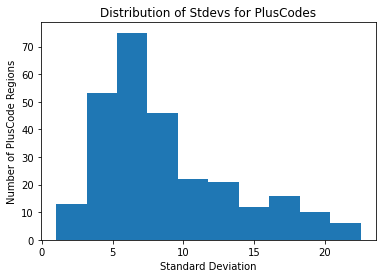

In [15]:
speed_variance_by_pluscode = speeds_to_gps.groupby(['plus_latitude_idx','plus_longitude_idx']).agg(np.std)['speed_mph_mean']# compute traffic speed variance in each plus code region

average_variance_by_pluscode = speed_variance_by_pluscode.mean()
variance_average_by_pluscode = speeds_to_gps.groupby(['plus_latitude_idx','plus_longitude_idx']).agg(np.mean)['speed_mph_mean'].std()
plt.hist(speed_variance_by_pluscode)
plt.title('Distribution of Stdevs for PlusCodes')
plt.xlabel('Standard Deviation')
plt.ylabel('Number of PlusCode Regions');


<!-- END QUESTION -->

<!--
BEGIN QUESTION
name: q1bv3
points: 3
-->

In [16]:
speed_variance_by_pluscode

plus_latitude_idx  plus_longitude_idx
3128               -10209                 3.650232
                   -10197                20.704487
                   -10193                12.342234
3129               -10209                 4.083821
                   -10198                21.390912
                                           ...    
3160               -10197                15.293632
                   -10196                17.915911
                   -10195                14.243592
                   -10194                12.237229
                   -10193                17.590817
Name: speed_mph_mean, Length: 276, dtype: float64

In [17]:
grader.check("q1bv3")

q1bv3 results: All test cases passed!

## 1.c. Map traffic speed to census tract.

Census tracts divide the space much less uniformly, subdividing regions that we were interested in into smaller zones. This suggests promise in providing informative spatial segments. Note that the daily traffic speeds are provided between OpenStreetMap (OSM) nodes, so we'll need to map nodes to census tracts somehow.

Above, we've mapped traffic speeds to GPS coordinates. Below, we'll then link GPS coordinates to census tracts, to complete the mapping from traffic speeds to census tracts.

### 1.c.i. Download Census Tracts Geojson

**Load the census tracts geojson.** Make sure to see the relevant [geopandas io documentation](https://geopandas.org/docs/user_guide/io.html) to see how to load a geojson.

**Hint**: It should take you just one line to load.

<!--
BEGIN QUESTION
name: q1ci
points: 1
-->

In [18]:
PATH_TRACTS = os.path.expanduser('data/san_francisco_censustracts.json')
tract_to_gps = gpd.read_file(PATH_TRACTS)
tract_to_gps['MOVEMENT_ID'] = tract_to_gps['MOVEMENT_ID'].astype(int)
tract_to_gps

MOVEMENT_ID                                       DISPLAY_NAME  \
0               1                            Sargent Creek, San Ardo   
1               2  400 Northumberland Avenue, Redwood Oaks, Redwo...   
2               3                18300 Sutter Boulevard, Morgan Hill   
3               4          2700 Stoughton Way, Sheffield, Sacramento   
4               5     3200 Huntsman Drive, Rosemont Park, Sacramento   
...           ...                                                ...   
2705         2706                     10000 Bobbell Drive, Elk Grove   
2706         2707                        400 Ericwood Court, Manteca   
2707         2708  200 Westview Drive, Sunshine Gardens, South Sa...   
2708         2709                1200 Halyard Drive, West Sacramento   
2709         2710   2500 Clubhouse Drive West, Whitney Oaks, Rocklin   

                                               geometry  
0     MULTIPOLYGON (((-121.59511 36.11126, -121.5401...  
1     MULTIPOLYGON (((-122.22463 37.46507, -122.2236...  
2     MULTIPOLYGON (((-121.67978 37.15859, -121.6719...  
3     MULTIPOLYGON (((-121.35921 38.57175, -121.3462...  
4     MULTIPOLYGON (((-121.37512 38.55309, -121.3715...  
...                                                 ...  
2705  MULTIPOLYGON (((-121.48392 38.40874, -121.4787...  
2706  MULTIPOLYGON (((-121.22695 37.82647, -121.2185...  
2707  MULTIPOLYGON (((-122.45179 37.66912, -122.4506...  
2708  MULTIPOLYGON (((-121.58346 38.57860, -121.5827...  
2709  MULTIPOLYGON (((-121.25720 38.82472, -121.2545...  

[2710 rows x 3 columns]

In [19]:
grader.check("q1ci")

q1ci results: All test cases passed!

### 1.c.ii Map traffic speed to census tracts.

You will need to *spatially join* the (1) mapping from traffic speed to GPS coordinates `speed_to_gps` and (2) the mapping from GPS coordinates to boundaries of census tracts `tract_to_gps` to group all traffic speeds by census tract. This "spatial join" is an advanced feature recently released (as of time of writing, in Oct 2021) in geopandas, which allows us to connect single points to their enclosing polygons. You will do this question in 3 parts:

1. Convert the last dataframe `speeds_to_gps` into a geopandas dataframe `speeds_to_points`, where GPS coordinates are now geopandas points. See this tutorial: https://geopandas.org/gallery/create_geopandas_from_pandas.html#From-longitudes-and-latitudes
2. Set the coordinate-system for the new geopandas dataframe to the "world geodesic system" [link](https://epsg.io/4326), or in other words, the coordinate system that GPS coordinates are reported in.
3. Compute a spatial join between census tracts `tract_to_gps` and the geopandas traffic speeds `speeds_to_points`

<!--
BEGIN QUESTION
name: q1cii
points: 4
-->

In [20]:
speeds_to_points = gpd.GeoDataFrame(speeds_to_gps, geometry=gpd.points_from_xy(speeds_to_gps.Longitude, speeds_to_gps.Latitude))
speeds_to_points = speeds_to_points.set_crs('EPSG:4326')
speeds_to_tract = speeds_to_points.sjoin(tract_to_gps, how="left")

speeds_to_tract

osm_start_node_id  osm_end_node_id  day  speed_mph_mean  osm_node_id  \
0                26118026        259458979    1       64.478000     26118026   
1                26118026        259458979    2       62.868208     26118026   
2                26118026        259458979    3       62.211750     26118026   
3                26118026        259458979    4       62.192458     26118026   
4                26118026        259458979    5       61.913292     26118026   
...                   ...              ...  ...             ...          ...   
417634         4069109544        615120176   30       38.956000   4069109544   
417635         5448539901         65446993   16       25.627000   5448539901   
417636          302964668       4069109544   19       40.802000    302964668   
417637          302964668       4069109544   20       36.076000    302964668   
417638         5022068066        302964668   19       39.592000   5022068066   

         Latitude   Longitude  plus_latitude_idx  plus_longitude_idx  \
0       37.675280 -122.389194               3139              -10199   
1       37.675280 -122.389194               3139              -10199   
2       37.675280 -122.389194               3139              -10199   
3       37.675280 -122.389194               3139              -10199   
4       37.675280 -122.389194               3139              -10199   
...           ...         ...                ...                 ...   
417634  37.732039 -122.507126               3144              -10208   
417635  37.622476 -122.413763               3135              -10201   
417636  37.732418 -122.507206               3144              -10208   
417637  37.732418 -122.507206               3144              -10208   
417638  37.733635 -122.507100               3144              -10208   

                           geometry  index_right  MOVEMENT_ID  \
0       POINT (-122.38919 37.67528)         1729         1730   
1       POINT (-122.38919 37.67528)         1729         1730   
2       POINT (-122.38919 37.67528)         1729         1730   
3       POINT (-122.38919 37.67528)         1729         1730   
4       POINT (-122.38919 37.67528)         1729         1730   
...                             ...          ...          ...   
417634  POINT (-122.50713 37.73204)         1778         1779   
417635  POINT (-122.41376 37.62248)         1456         1457   
417636  POINT (-122.50721 37.73242)         1778         1779   
417637  POINT (-122.50721 37.73242)         1778         1779   
417638  POINT (-122.50710 37.73363)         1778         1779   

                                         DISPLAY_NAME  
0                               0 Park Lane, Brisbane  
1                               0 Park Lane, Brisbane  
2                               0 Park Lane, Brisbane  
3                               0 Park Lane, Brisbane  
4                               0 Park Lane, Brisbane  
...                                               ...  
417634  500 John Muir Drive, Lakeshore, San Francisco  
417635                  1500 Donner Avenue, San Bruno  
417636  500 John Muir Drive, Lakeshore, San Francisco  
417637  500 John Muir Drive, Lakeshore, San Francisco  
417638  500 John Muir Drive, Lakeshore, San Francisco  

[418848 rows x 13 columns]

In [21]:
grader.check("q1cii")

q1cii results: All test cases passed!

### 1.c.iii. Aggregate movement speeds by census tract.

- Create a new dataframe `speeds_by_tract` to group movement speeds by census tract. See the outputted dataframe from 1.c.i. to check how census tracts are identified.
- Always double-check your numbers. **Report the number of census tracts** in your dataset.

<!--
BEGIN QUESTION
name: q1ciii
points: 2
-->

In [22]:
speeds_by_tract = speeds_to_tract.groupby('MOVEMENT_ID')
num_census_tracts = len(speeds_to_tract.groupby('MOVEMENT_ID').size())
num_census_tracts

295

In [23]:
grader.check("q1ciii")

q1ciii results: All test cases passed!

<!-- BEGIN QUESTION -->

### 1.c.iv. How well do census tracts summarize movement speeds?

The following will give us an idea of how well the average represents traffic speed per plus code region. For these questions, we'll refer to a "census tract" as a "cluster":

1. **Plot a histogram of the within-cluster standard deviation**.
2. **Compute across-cluster average of within-cluster standard deviation**.
3. **Compute across-cluster standard deviation of within-cluster average speeds**.
4. **Is this average variance reasonable?** To assess what "reasonable" means, consider these questions and how to answer them: (1) Do plus codes capture meaningful subpopulations? (2) Do differences between subpopulations outweigh differences within a subpopulation? Use these ideas to assess whether the average standard deviation is high or not.

Note: We are using the speed metric of miles per hour here.

Just like before, please written answers in the first cell and coding answers in the second cell.
<!--5. Using the above, how would you **compare census tracts to plus codes, in terms of its effectiveness** as a spatial clustering mechanism for analyzing traffic speeds? Compare the statistics you've computed. What does it mean for one to be higher than the other?-->

<!--
BEGIN QUESTION
name: q1civ1
points: 2
manual: True
-->



4. This time, the average variance is reasonable, and the spatial clustering is a lot more representative of the data they encompass. The average variance by tract is more in line with the across clsuter variance average for census tracts. The tail of the histogram is relatively smaller compared to the tail of the plus code histogram, and the average variance by tract clustering is lower compared to the average variance by plus code, so this seems like a better spatial encoding.

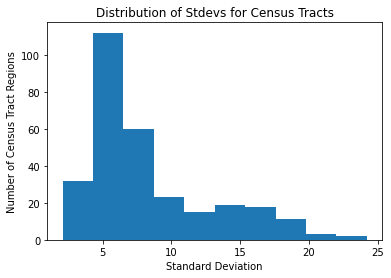

In [24]:
plt.hist(speeds_to_tract.groupby('MOVEMENT_ID').agg(np.std)['speed_mph_mean'])
plt.title('Distribution of Stdevs for Census Tracts')
plt.xlabel('Standard Deviation')
plt.ylabel('Number of Census Tract Regions');

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!--
BEGIN QUESTION
name: q1civ2
points: 2
manual: True
-->

In [25]:
speeds_to_tract.groupby('MOVEMENT_ID').agg(np.std)

osm_start_node_id  osm_end_node_id       day  speed_mph_mean  \
MOVEMENT_ID                                                                 
9                 1.699601e+09     1.661318e+09  8.561287        3.821144   
20                6.941097e+08     9.991617e+08  8.636868        5.522853   
21                1.549197e+09     1.408258e+09  4.317201        3.640453   
44                2.164862e+09     2.172881e+09  7.579068        6.634154   
78                1.767481e+09     2.019760e+09  5.177747        3.838873   
...                        ...              ...       ...             ...   
2691              2.190798e+04     1.736377e+04  3.309438        3.379664   
2694              1.760004e+09     1.743062e+09  8.184973        5.787065   
2695              2.221266e+09     2.301651e+09  5.799584        4.617596   
2700              2.130256e+09     2.072269e+09  7.427401       13.191079   
2708              1.801903e+09     1.825297e+09  5.345488        7.136608   

              osm_node_id  Latitude  Longitude  plus_latitude_idx  \
MOVEMENT_ID                                                         
9            1.699601e+09  0.000804   0.000967           0.000000   
20           6.941097e+08  0.000472   0.002250           0.468397   
21           1.549197e+09  0.001168   0.001172           0.000000   
44           2.164862e+09  0.002510   0.002326           0.310918   
78           1.767481e+09  0.002945   0.002992           0.449092   
...                   ...       ...        ...                ...   
2691         2.190798e+04  0.000505   0.003673           0.000000   
2694         1.760004e+09  0.000756   0.003028           0.473769   
2695         2.221266e+09  0.001892   0.003580           0.000000   
2700         2.130256e+09  0.005251   0.007093           0.498988   
2708         1.801903e+09  0.003364   0.006019           0.363957   

             plus_longitude_idx  index_right  
MOVEMENT_ID                                   
9                      0.000000          0.0  
20                     0.000000          0.0  
21                     0.000000          0.0  
44                     0.393078          0.0  
78                     0.498637          0.0  
...                         ...          ...  
2691                   0.487950          0.0  
2694                   0.000000          0.0  
2695                   0.000000          0.0  
2700                   0.574440          0.0  
2708                   0.643241          0.0  

[295 rows x 10 columns]

In [26]:
speed_variance_by_tract = speeds_to_tract.groupby('MOVEMENT_ID').agg(np.std)['speed_mph_mean']
average_variance_by_tract = speed_variance_by_tract.mean()
variance_average_by_tract = speeds_to_tract.groupby('MOVEMENT_ID').agg(np.mean)['speed_mph_mean'].std()

<!-- END QUESTION -->

<!--
BEGIN QUESTION
name: q1civ3
points: 3
-->

In [27]:
speed_variance_by_tract

MOVEMENT_ID
9        3.821144
20       5.522853
21       3.640453
44       6.634154
78       3.838873
          ...    
2691     3.379664
2694     5.787065
2695     4.617596
2700    13.191079
2708     7.136608
Name: speed_mph_mean, Length: 295, dtype: float64

In [28]:
grader.check("q1civ3")

q1civ3 results: All test cases passed!

<!-- BEGIN QUESTION -->

## 1.d. What would be the ideal spatial clustering?

This is an active research problem in many spatiotemporal modeling communities, and there is no single agreed-upon answer. Answer both of the following specifically knowing that you'll need to analyze traffic patterns according to this spatial clustering:

1. **What is a good metric for a spatial structure?** How do we define good? Bad? What information do we expect a spatial structure to yield? Use the above parts and questions to help answer this.
2. **What would you do to optimize your own metric for success in a spatial structure?**

See related articles:

- Uber's H3 [link](https://eng.uber.com/h3/), which divides the world into hexagons
- Traffic Analysis Zones (TAZ) [link](https://en.wikipedia.org/wiki/Traffic_analysis_zone), which takes census data and additionally accounts for vehicles per household when dividing space

<!--
BEGIN QUESTION
name: q1d
points: 3
manual: True
-->

1. A good metric would be looking the average variance within each cluster relative to the variance of the dataset to compare to other spatial clustering models. A good spatial clustering is representative of a population, without too much variance, while bad spatial clustering is unrepresentative and results in high variance for the parameter we are trying to study. We expect a spatial structure to yield movement data for cars within a region.

2. We would want to minimize the variance across clusters for each spatial structure. We could potentially use an algorithm for a given parameter (such as k-means clustering) to minimize the variance to find the best spatial structure to use.

<!-- END QUESTION -->



# Step 2 - Guided EDA: Understanding COVID Lockdown Impact on Traffic

In this step, we'll examine the impact of COVID on traffic. In particular, we'll study 3 different questions:

- How did lockdown affect traffic speed? What factors dictate how much lockdown affected traffic speed?
- What areas of traffic were most impacted by lockdown?

## 2.a. How did lockdown affect traffic speed?

<!-- BEGIN QUESTION -->

### 2.a.i. Sort census tracts by average speed, pre-lockdown.

Consider the pre-lockdown period to be March 1 - 13, before the first COVID-related restrictions (travel bans) were announced on March 14, 2020.

1. **Report a DataFrame which includes the *names* of the 10 census tracts with the lowest average speed**, along with the average speed for each tract.
2. **Report a DataFrame which includes the *names* of the 10 census tracts with the highest average speed**, along with the average speed for each tract.
2. Do these names match your expectations for low speed or high speed traffic pre-lockdown?  What relationships do you notice? (What do the low-speed areas have in common? The high-speed areas?) For this specific question, answer qualitatively. No need to quantify. **Hint**: Look up some of the names on a map, to understand where they are.
3. **Plot a histogram for all average speeds, pre-lockdown**.
4. You will notice a long tail distribution of high speed traffic. What do you think this corresponds to in San Francisco? Write down your hypothesis.

Hint: To start off, think about what joins may be useful to get the desired DataFrame.

<!--
BEGIN QUESTION
name: q2ai1
points: 3
manual: True
-->

3. By personal experience, these names do match expectations as it seems they are neighborhoods with a lot of traffic lights, surface streets, and crosswalks. For high-speed names, there tend to be more isolated straighter roads with fewer pedestrians and attractions.

5. Our hypothesis is that there are a few high speed drivers within certain tracts with high speed limits(freeways). This can also come from drivers who tend to drive faster in specific tracts with low speed limits.

<!-- END QUESTION -->

Answer the following question:
<!--
BEGIN QUESTION
name: q2ai2
points: 3
-->

In [29]:
pre = speeds_to_tract[speeds_to_tract['day']<14]
merged = pre[['geometry','MOVEMENT_ID','DISPLAY_NAME']]

In [30]:
# compute the average speed per census tract (will use this later),
# BEFORE the shelter-in-place was announced on March 14, 2020.
# Autograder expects this to be a series
averages_pre = pre.groupby('MOVEMENT_ID').mean()['speed_mph_mean']
# Autograder expects this to be a dataframe with name of census tract,
# polygon for census tract, and average speed per census tract
averages_pre_named = merged.merge(averages_pre.to_frame(),left_on = 'MOVEMENT_ID', right_on = 'MOVEMENT_ID').set_index('MOVEMENT_ID').drop_duplicates(subset = ['DISPLAY_NAME'])
averages_pre_named

geometry  \
MOVEMENT_ID                                
1730         POINT (-122.38919 37.67528)   
209          POINT (-122.39889 37.71689)   
1729         POINT (-122.37650 37.59988)   
1449         POINT (-122.40595 37.64217)   
2127         POINT (-122.51679 37.88236)   
...                                  ...   
1951         POINT (-122.41136 37.71061)   
2320         POINT (-122.41597 37.70899)   
1272         POINT (-122.42844 37.72165)   
2691         POINT (-122.41621 37.60090)   
499          POINT (-122.53839 37.89652)   

                                                  DISPLAY_NAME  speed_mph_mean  
MOVEMENT_ID                                                                     
1730                                     0 Park Lane, Brisbane       36.319986  
209          300 Wilde Avenue, Visitacion Valley, San Franc...       27.823270  
1729           1500 Adrian Road, Ingold - Milldale, Burlingame       30.290830  
1449         500 Forbes Boulevard, The East Side, South San...       28.853958  
2127                             0 Hamilton Drive, Mill Valley       35.238851  
...                                                        ...             ...  
1951         400 Delta Street, Visitacion Valley, San Franc...       16.393633  
2320         300 Argonaut Avenue, Visitacion Valley, San Fr...       21.088676  
1272               500 Moscow Street, Excelsior, San Francisco       15.378289  
2691                                800 Hacienda Way, Millbrae       20.746333  
499                       600 Throckmorton Avenue, Mill Valley       17.229625  

[295 rows x 3 columns]

In [31]:
grader.check("q2ai2")

q2ai2 results: All test cases passed!

Report the lowest 10 census tracts with the lowest average speed
Remember we want the NAME of each census tract too. For the autograder, please keep the name of the speed field, `speed_mph_mean`.

<!--
BEGIN QUESTION
name: q2ai3
points: 1
-->

In [32]:
bottom10_averages_pre = averages_pre_named.sort_values('speed_mph_mean').iloc[0:10,:][['DISPLAY_NAME','speed_mph_mean']]
bottom10_averages_pre

DISPLAY_NAME  speed_mph_mean
MOVEMENT_ID                                                                   
1691           200 O'Farrell Street, Tenderloin, San Francisco       12.417079
2340                 0 Mason Street, Tenderloin, San Francisco       12.595120
1688               1100 Taylor Street, Nob Hill, San Francisco       12.945291
651          2900 22nd Street, Mission District, San Francisco       13.195865
643               200 Myrtle Street, Tenderloin, San Francisco       13.490311
1689         200 Sutter Street, Financial District, San Fra...       13.502505
1244              800 Jackson Street, Chinatown, San Francisco       13.549474
1245               500 Geary Street, Tenderloin, San Francisco       13.570625
644                200 Jones Street, Tenderloin, San Francisco       13.626251
1674                200 Hyde Street, Tenderloin, San Francisco       13.944773

In [33]:
grader.check("q2ai3")

q2ai3 results: All test cases passed!

Report the highest 10 census tracts with the highest average speed.

<!--
BEGIN QUESTION
name: q2ai4
points: 1
-->

In [34]:
top10_averages_pre = averages_pre_named.sort_values('speed_mph_mean',ascending = False).iloc[0:10,:][['DISPLAY_NAME','speed_mph_mean']]
top10_averages_pre

DISPLAY_NAME  speed_mph_mean
MOVEMENT_ID                                                                   
285                              1600 Maritime Street, Oakland       59.498552
495                         4200 Shelter Creek Lane, San Bruno       53.867847
1653                                Petrolite Street, Richmond       47.318340
2339                      Frenchmans Creek Road, Half Moon Bay       47.225137
1744                                1200 Helen Drive, Millbrae       45.492292
2244         0 Crystal Springs Terrace, Hillsborough Park, ...       44.304919
2660                                0 Burgess Court, Sausalito       43.848188
1955                               Liccicitos Road, Moss Beach       42.784267
1732                     0 Longview Drive, Westlake, Daly City       40.587037
1743                      600 San Bruno Avenue East, San Bruno       38.944079

In [35]:
grader.check("q2ai4")

q2ai4 results: All test cases passed!

<!-- BEGIN QUESTION -->

Plot the histogram
<!--
BEGIN QUESTION
name: q2ai5
points: 1
manual: True
-->

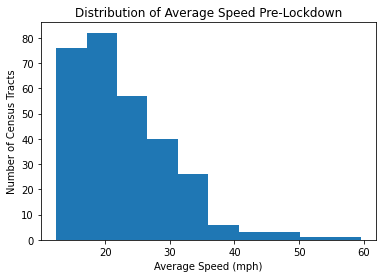

In [36]:
plt.hist(averages_pre)
plt.title('Distribution of Average Speed Pre-Lockdown')
plt.xlabel('Average Speed (mph)')
plt.ylabel('Number of Census Tracts');

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### 2.a.ii. Sort census tracts by average speed, post-lockdown.

I suggest checking the top 10 and bottom 10 tracts by average speed, post-lockdown. Consider the post-lockdown period to be March 14 - 31, after the first COVID restrictions were established on March 14, 2020. It's a healthy sanity check. For this question, you should report:

- **Plot a histogram for all average speeds, post-lockdown.**
- **What are the major differences between this post-lockdown histogram relative to the pre-lockdown histogram above**? Anything surprising? What did you expect, and what did you find?

Write the written answers in the cell below, and the coding answers in the cells after that.

<!--
BEGIN QUESTION
name: q2aii1
points: 1
manual: True
-->

1. The mean of the post-lockdown histogram(28.3 mph) is higher than the pre-lockdown mean(22.9 mph), and this change is also visible in the shift of the center in the histogram. This isn't very suprising as there are fewer cars on the road, thus drivers would tend to increase their speeds. The tail of the post-lockdown histogram curves upwards, while the pre-lockdown histogram is more flat. This could indicate that drivers post-lockdown tend to drive at higher average speeds, especially at extreme speeds.

In [37]:
post = speeds_to_tract[speeds_to_tract['day'] > 13]
mergedpost = post[['geometry','MOVEMENT_ID','DISPLAY_NAME']]

<!-- END QUESTION -->

<!--
BEGIN QUESTION
name: q2aii2
points: 2
-->

In [38]:
# compute the average speed per census tract (will use this later),
# AFTER (and including) the first COVID restrictions were put into effect.
# Autograder expects this to be a series
averages_post = post.groupby('MOVEMENT_ID').mean()['speed_mph_mean']
# Autograder expects this to be a dataframe with name of census tract,
# polygon for census tract, and average speed per census tract
averages_post_named = mergedpost.merge(averages_post.to_frame(),left_on = 'MOVEMENT_ID', right_on = 'MOVEMENT_ID').set_index('MOVEMENT_ID').drop_duplicates(subset = ['DISPLAY_NAME'])
averages_post_named

geometry  \
MOVEMENT_ID                                
1730         POINT (-122.38919 37.67528)   
209          POINT (-122.39889 37.71689)   
1729         POINT (-122.37650 37.59988)   
1449         POINT (-122.40595 37.64217)   
2127         POINT (-122.51679 37.88236)   
...                                  ...   
1752         POINT (-122.32079 37.54562)   
285          POINT (-122.32294 37.82261)   
1447         POINT (-122.40645 37.65747)   
1272         POINT (-122.42961 37.72010)   
2691         POINT (-122.41621 37.60090)   

                                                  DISPLAY_NAME  speed_mph_mean  
MOVEMENT_ID                                                                     
1730                                     0 Park Lane, Brisbane       43.282680  
209          300 Wilde Avenue, Visitacion Valley, San Franc...       31.190314  
1729           1500 Adrian Road, Ingold - Milldale, Burlingame       32.648621  
1449         500 Forbes Boulevard, The East Side, South San...       38.959931  
2127                             0 Hamilton Drive, Mill Valley       50.407098  
...                                                        ...             ...  
1752          200 West 25th Avenue, South San Mateo, San Mateo       29.218000  
285                              1600 Maritime Street, Oakland       63.993313  
1447               200 9th Lane, Downtown, South San Francisco       30.594889  
1272               500 Moscow Street, Excelsior, San Francisco       16.227233  
2691                                800 Hacienda Way, Millbrae       17.917000  

[285 rows x 3 columns]

In [39]:
grader.check("q2aii2")

q2aii2 results: All test cases passed!

<!-- BEGIN QUESTION -->

Plot the histogram
<!--
BEGIN QUESTION
name: q2aii3
points: 1
manual: True
-->

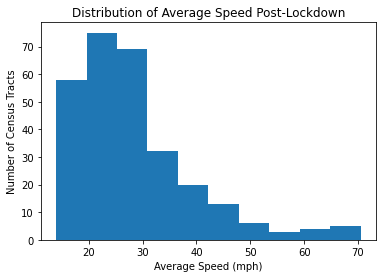

In [40]:
plt.hist(averages_post)
plt.title('Distribution of Average Speed Post-Lockdown')
plt.xlabel('Average Speed (mph)')
plt.ylabel('Number of Census Tracts');

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### 2.a.iii. Sort census tracts by change in traffic speed from pre to post lockdown.

For each segment, compute the difference between the pre-lockdown average speed (March 1 - 13) and the post-lockdown average speed (March 14 - 31). **Plot a histogram of all differences.** Sanity check that the below histogram matches your observations of the histograms above, on your own.

<!--
BEGIN QUESTION
name: q2aiii
points: 2
manual: True
-->

In [41]:
differences = (averages_post - averages_pre)

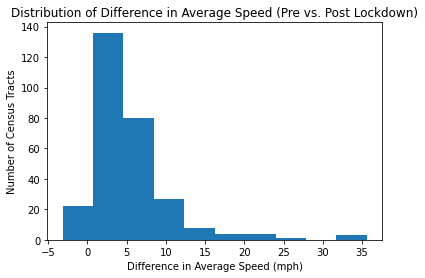

In [42]:
# The autograder expects differences to be a series object with index
# MOVEMENT_ID.
differences = differences.dropna()
# plot the differences
plt.hist(differences)
plt.title('Distribution of Difference in Average Speed (Pre vs. Post Lockdown)')
plt.xlabel('Difference in Average Speed (mph)')
plt.ylabel('Number of Census Tracts');

In [43]:
grader.check("q2aiii")

q2aiii results: All test cases passed!

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### 2.a.iv. Quantify the impact of lockdown on average speeds.

1. **Plot the average speed by day, across all segments**. Be careful not to plot the average of census tract averages instead. Recall the definition of segments from Q1.
2. Is the change in speed smooth and gradually increasing? Or increasing sharply? Why? Use your real-world knowledge of announcements and measures during that time, in your explanation. You can use this list of bay area COVID-related dataes: https://abc7news.com/timeline-of-coronavirus-us-covid-19-bay-area-sf/6047519/

<!--
BEGIN QUESTION
name: q2aiv1
points: 1
manual: True
-->

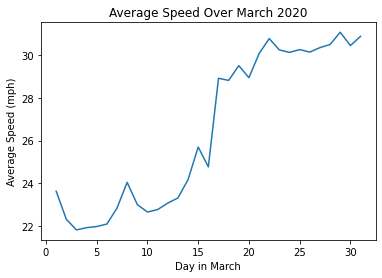

In [44]:
# Autograder expects this to be a series object containing the
# data for your line plot -- average speeds per day.
speeds_daily = speeds_to_tract.groupby('day').mean()['speed_mph_mean']
plt.plot(speeds_daily)
plt.title('Average Speed Over March 2020')
plt.xlabel('Day in March')
plt.ylabel('Average Speed (mph)');

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

Write your written answer in the cell below

<!--
BEGIN QUESTION
name: q2aiv2
points: 1
manual: True
-->

2. The changes in speed seem to increase sharply. These sharp increases could represent major increases in restrictions across the bay area (i.e. March 17-Shelter in-place in the Bay Area). This resulted in fewer cars on the road, thus faster averages speeds.

<!-- END QUESTION -->

Ignore the empty cell below, just run the autograder to test the code above is correct.
<!--
BEGIN QUESTION
name: q2aiv3
points: 1
-->

In [45]:
grader.check("q2aiv3")

q2aiv3 results: All test cases passed!

<!-- BEGIN QUESTION -->

### 2.a.v. Quantify the impact of pre-lockdown average speed on change in speed.

1. Compute the correlation between change in speed and the *pre*-lockdown average speeds. Do we expect a positive or negative correlation, given our analysis above?
2. Compute the correlation between change in speed and the post-lockdown average speeds.
3. **How does the correlation in Q1 compare with the correlation in Q2?** You should expect a significant change in correlation value. What insight does this provide about traffic?

Written answers in the first cell, coding answerts in the following cell.

<!--
BEGIN QUESTION
name: q2av1
points: 2
manual: True
-->

3. Correlation between the pre-lockdown speeds and the differences is lower than the correlation between the post-lockdown speeds and differences. We expect both correlations to be postive, because the averages of the pre-lockdown speeds, post-lockdown speeds, and differences were all increasing on average. However, the post-lockdown speeds had a stronger increasing trend compared to the pre-lockdown speeds, so therefore the correlation between the post-lockdown speeds and differences is stronger. This implys that the post-lockdown average speeds explains more about the changes in speed than the pre-lockdown average speeds. It indicates that the changes in traffic speeds can be explained by the status of the lockdown.

<!-- END QUESTION -->


<!--
BEGIN QUESTION
name: q2av2
points: 2
-->

In [46]:
seri = differences + 2 * averages_pre - averages_post
seri = seri.dropna()
corr_pre_diff = np.corrcoef(seri,differences)[1][0]
corr_post_diff = np.corrcoef(averages_post,differences)[1][0]
corr_pre_diff, corr_post_diff

(0.46330063805801835, 0.7926799984780658)

In [47]:
grader.check("q2av2")

q2av2 results: All test cases passed!

## 2.b. What traffic areas were impacted by lockdown?

<!-- BEGIN QUESTION -->

### 2.b.i. Visualize spatial heatmap of average traffic speed per census tract, pre-lockdown.

Visualize a spatial heatmap of the grouped average daily speeds per census tract, which you computed in previous parts. Use the geopandas [chloropleth maps](https://geopandas.org/docs/user_guide/mapping.html#choropleth-maps). **Write your observations, using your visualization, noting down at least 2 areas or patterns of interest**. These may be a local extrema, or a region that is strangely all similar.

**Hint**: Use [`to_crs`](https://geopandas.org/docs/reference/api/geopandas.GeoDataFrame.to_crs.html) and make sure the `epsg` is using the Pseudo-Mercator projection.

**Hint**: You can use `contextily` to superimpose your chloropleth map on a real geographic map.

**Hint** You can set a lower opacity for your chloropleth map, to see what's underneath, but be aware that if you plot with too low of an opacity, the map underneath will perturb your chloropleth and meddle with your conclusions.

Written answers in the first cell, coding answers in the second cell.

<!--
BEGIN QUESTION
name: q2bi1
points: 1
manual: True
-->

- The downtown area has much lower average speeds compared to the rest of the city. This could be the result of more pedestrians and an greater overall population.

- The further south you go, the faster the average speed, which results from fewer populations and less people on the road.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!--
BEGIN QUESTION
name: q2bi2
points: 4
manual: True
-->

In [48]:
averages_pre_named['diff'] = differences
averages_pre_named.dropna()

geometry  \
MOVEMENT_ID                                
1730         POINT (-122.38919 37.67528)   
209          POINT (-122.39889 37.71689)   
1729         POINT (-122.37650 37.59988)   
1449         POINT (-122.40595 37.64217)   
2127         POINT (-122.51679 37.88236)   
...                                  ...   
1752         POINT (-122.32079 37.54562)   
285          POINT (-122.32294 37.82261)   
1447         POINT (-122.40645 37.65747)   
1272         POINT (-122.42844 37.72165)   
2691         POINT (-122.41621 37.60090)   

                                                  DISPLAY_NAME  \
MOVEMENT_ID                                                      
1730                                     0 Park Lane, Brisbane   
209          300 Wilde Avenue, Visitacion Valley, San Franc...   
1729           1500 Adrian Road, Ingold - Milldale, Burlingame   
1449         500 Forbes Boulevard, The East Side, South San...   
2127                             0 Hamilton Drive, Mill Valley   
...                                                        ...   
1752          200 West 25th Avenue, South San Mateo, San Mateo   
285                              1600 Maritime Street, Oakland   
1447               200 9th Lane, Downtown, South San Francisco   
1272               500 Moscow Street, Excelsior, San Francisco   
2691                                800 Hacienda Way, Millbrae   

             speed_mph_mean       diff  
MOVEMENT_ID                             
1730              36.319986   6.962694  
209               27.823270   3.367045  
1729              30.290830   2.357791  
1449              28.853958  10.105973  
2127              35.238851  15.168247  
...                     ...        ...  
1752              24.449609   4.768391  
285               59.498552   4.494760  
1447              31.797557  -1.202668  
1272              15.378289   0.848945  
2691              20.746333  -2.829333  

[285 rows x 4 columns]

In [49]:
averages_pre_named

geometry  \
MOVEMENT_ID                                
1730         POINT (-122.38919 37.67528)   
209          POINT (-122.39889 37.71689)   
1729         POINT (-122.37650 37.59988)   
1449         POINT (-122.40595 37.64217)   
2127         POINT (-122.51679 37.88236)   
...                                  ...   
1951         POINT (-122.41136 37.71061)   
2320         POINT (-122.41597 37.70899)   
1272         POINT (-122.42844 37.72165)   
2691         POINT (-122.41621 37.60090)   
499          POINT (-122.53839 37.89652)   

                                                  DISPLAY_NAME  \
MOVEMENT_ID                                                      
1730                                     0 Park Lane, Brisbane   
209          300 Wilde Avenue, Visitacion Valley, San Franc...   
1729           1500 Adrian Road, Ingold - Milldale, Burlingame   
1449         500 Forbes Boulevard, The East Side, South San...   
2127                             0 Hamilton Drive, Mill Valley   
...                                                        ...   
1951         400 Delta Street, Visitacion Valley, San Franc...   
2320         300 Argonaut Avenue, Visitacion Valley, San Fr...   
1272               500 Moscow Street, Excelsior, San Francisco   
2691                                800 Hacienda Way, Millbrae   
499                       600 Throckmorton Avenue, Mill Valley   

             speed_mph_mean       diff  
MOVEMENT_ID                             
1730              36.319986   6.962694  
209               27.823270   3.367045  
1729              30.290830   2.357791  
1449              28.853958  10.105973  
2127              35.238851  15.168247  
...                     ...        ...  
1951              16.393633        NaN  
2320              21.088676        NaN  
1272              15.378289   0.848945  
2691              20.746333  -2.829333  
499               17.229625        NaN  

[295 rows x 4 columns]

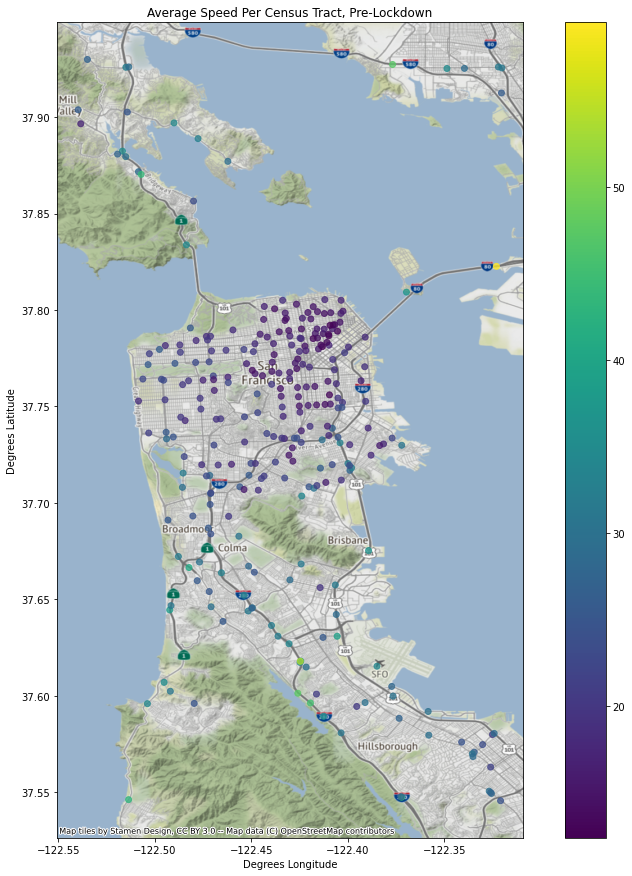

In [50]:
gdf = gpd.GeoDataFrame(averages_pre_named, geometry=averages_pre_named['geometry'], crs="EPSG:4326")
ax = gdf.plot(column='speed_mph_mean',figsize = (15,15),alpha = 0.75, legend = True)
ax.set_xlabel('Degrees Longitude')
ax.set_ylabel('Degrees Latitude')
ax.set_title('Average Speed Per Census Tract, Pre-Lockdown')
cx.add_basemap(ax,crs = gdf.crs.to_string())

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### 2.b.ii. Visualize change in average daily speeds pre vs. post lockdown.

Visualize a spatial heatmap of the census tract differences in average speeds, that we computed in a previous part. **Write your observations, using your visualization, noting down at least 2 areas or patterns of interest.** Some possible ideas for interesting notes: Which areas saw the most change in average speed? Which areas weren't affected? Why did some areas see *reduced* average speed?

First cell is for the written answers, second cell is for the coding answers.

<!--
BEGIN QUESTION
name: q2bii1
points: 1
manual: True
-->

1. The downtown area did not see a great of a change in average speeds. This is generally due to lower speed limits and street designs(Stop signs,traffic lights).The freeways of the city saw a greater increase in speeds, which is due to less traffic and the speed of the freeways is more directly affected by the number of cars on the road.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!--
BEGIN QUESTION
name: q2bii2
points: 4
manual: True
-->

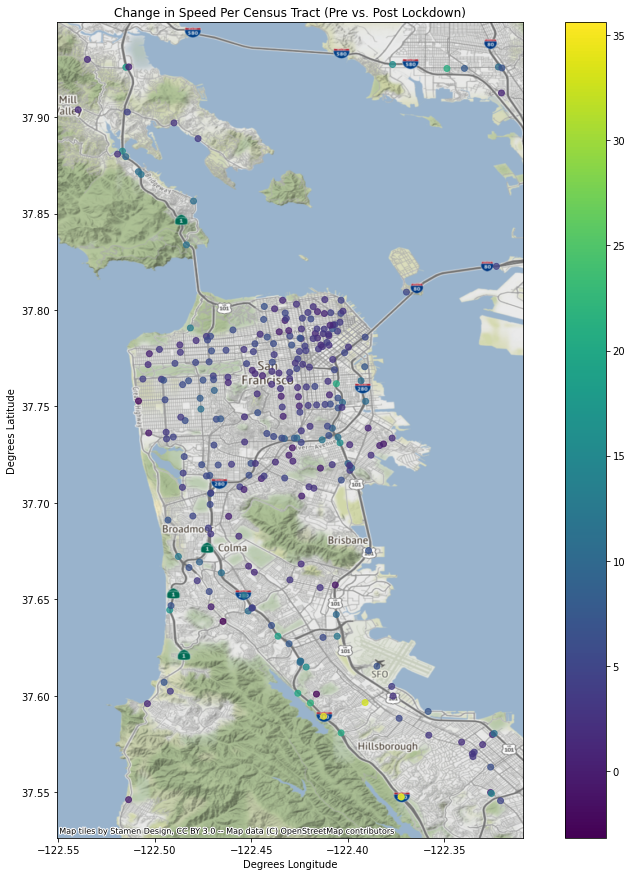

In [51]:
gdfz = gpd.GeoDataFrame(averages_pre_named, geometry=averages_pre_named['geometry'], crs="EPSG:4326")
axz = gdfz.plot(column='diff',figsize = (15,15),alpha = 0.75, legend = True)
axz.set_xlabel('Degrees Longitude')
axz.set_ylabel('Degrees Latitude')
axz.set_title('Change in Speed Per Census Tract (Pre vs. Post Lockdown)')
cx.add_basemap(axz,crs = gdfz.crs.to_string())

<!-- END QUESTION -->



# Step 3 - Open-Ended EDA: Understanding lockdown impact on travel times

Explore daily travel times from Hayes Valley to other destinations both before and throughout lockdown. Use the following questions as suggestions for what to explore, temporally and spatially:

- How did lockdown affect travel times? Are there any meaningful factors that determined how travel time would be impacted? How was travel time affected over time?
- Travel to which destinations were affected by lockdown? Are there surprisingly disproportionate amounts of impact in certain areas?

## 3.a. Load Datasets

In this step, we will load two datasets:

- Daily travel times from Hayes Valley to all other census tracts around San Francisco.
- Daily travel times from 300 Hayes St to Golden Gate Park in San Francisco.

For this specific set of data, we can ask several more questions; which questions you pursue are up to you, including any that you come up that are not on this list:

- Which routes from Hayes Valley had similar impact on travel time? Did they share any factors in common? Traveling through the same place -- e.g., a freway? Traveling in similar areas e.g., residential areas?
- Were clusters of routes impacted more severely than others over time? What determined the degree of impact?

In [52]:
PATH_TIMES = 'data/travel-times-daily-san-francisco-2020-3.csv'
times_to_tract = pd.read_csv(PATH_TIMES)
times_to_tract

Origin Movement ID                            Origin Display Name  \
0                    1277  300 Hayes Street, Civic Center, San Francisco   
1                    1277  300 Hayes Street, Civic Center, San Francisco   
2                    1277  300 Hayes Street, Civic Center, San Francisco   
3                    1277  300 Hayes Street, Civic Center, San Francisco   
4                    1277  300 Hayes Street, Civic Center, San Francisco   
...                   ...                                            ...   
10333                1277  300 Hayes Street, Civic Center, San Francisco   
10334                1277  300 Hayes Street, Civic Center, San Francisco   
10335                1277  300 Hayes Street, Civic Center, San Francisco   
10336                1277  300 Hayes Street, Civic Center, San Francisco   
10337                1277  300 Hayes Street, Civic Center, San Francisco   

       Destination Movement ID  \
0                            9   
1                           20   
2                           21   
3                           44   
4                           46   
...                        ...   
10333                     2624   
10334                     2643   
10335                     2673   
10336                     2694   
10337                     2695   

                                Destination Display Name  \
0             500 Hyde Street, Tenderloin, San Francisco   
1       900 Sutter Street, Lower Nob Hill, San Francisco   
2      3400 Pierce Street, Marina District, San Franc...   
3             1700 Egbert Avenue, Bayview, San Francisco   
4              500 Chester Street, West Oakland, Oakland   
...                                                  ...   
10333      1300 16th Avenue, Inner Sunset, San Francisco   
10334         1300 Egbert Avenue, Bayview, San Francisco   
10335  100 Rutledge Street, Bernal Heights, San Franc...   
10336  1900 Buchanan Street, Western Addition, San Fr...   
10337  2200 Rivera Street, Sunset District, San Franc...   

                                            Date Range  \
0        3/1/2020 - 3/1/2020, Every day, Daily Average   
1        3/1/2020 - 3/1/2020, Every day, Daily Average   
2        3/1/2020 - 3/1/2020, Every day, Daily Average   
3        3/1/2020 - 3/1/2020, Every day, Daily Average   
4        3/1/2020 - 3/1/2020, Every day, Daily Average   
...                                                ...   
10333  3/31/2020 - 3/31/2020, Every day, Daily Average   
10334  3/31/2020 - 3/31/2020, Every day, Daily Average   
10335  3/31/2020 - 3/31/2020, Every day, Daily Average   
10336  3/31/2020 - 3/31/2020, Every day, Daily Average   
10337  3/31/2020 - 3/31/2020, Every day, Daily Average   

       Mean Travel Time (Seconds)  Range - Lower Bound Travel Time (Seconds)  \
0                             322                                        211   
1                             291                                        179   
2                             635                                        438   
3                             786                                        566   
4                             891                                        682   
...                           ...                                        ...   
10333                         502                                        411   
10334                         571                                        475   
10335                         367                                        265   
10336                         222                                        167   
10337                         917                                        778   

       Range - Upper Bound Travel Time (Seconds)  day  
0                                            489    1  
1                                            470    1  
2                                            920    1  
3                                           1090    1  
4                         

In [53]:
withgeometry = times_to_tract.merge(tract_to_gps, left_on = 'Destination Movement ID',right_on = 'MOVEMENT_ID')
geoone = gpd.GeoDataFrame(withgeometry, geometry='geometry',crs="EPSG:4326")

In [54]:
prelockdown = geoone[geoone['day'] <= 13]
postlockdown = geoone[geoone['day'] > 13]

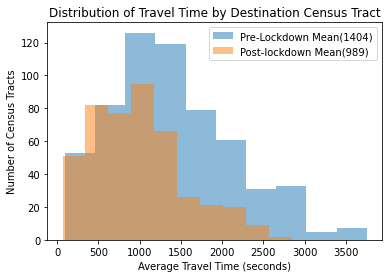

In [55]:
plt.hist(prelockdown.groupby(['Destination Movement ID']).mean()['Mean Travel Time (Seconds)'],alpha=0.5, label = 'Pre-Lockdown Mean(1404)')
plt.hist(postlockdown.groupby(['Destination Movement ID']).mean()['Mean Travel Time (Seconds)'],alpha=0.5,label = 'Post-lockdown Mean(989)')
plt.title('Distribution of Travel Time by Destination Census Tract')
plt.xlabel('Average Travel Time (seconds)')
plt.ylabel('Number of Census Tracts')
plt.legend();

Here is the distribution for the Mean Travel Times from Hayes valley to other Destination Movement IDs pre-lockdown vs post-lockdown. Although there are fewer data points in the post-lockdown dataframe, you can see an obvious decrease in mean travel times.

In [56]:
import seaborn as sns

In [57]:
mergedmeans = postlockdown.groupby(['Destination Movement ID']).mean().merge(prelockdown.groupby(['Destination Movement ID']).mean(), left_index=True, right_index=True)

In [58]:
mergedmeans['diff'] =  mergedmeans['Mean Travel Time (Seconds)_y'] - mergedmeans['Mean Travel Time (Seconds)_x'] 

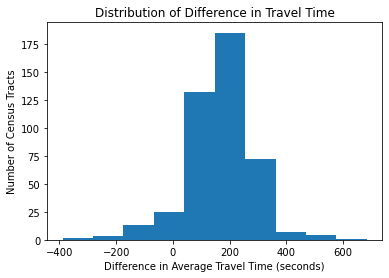

In [59]:
plt.hist(mergedmeans['diff'])
plt.title('Distribution of Difference in Travel Time')
plt.xlabel('Difference in Average Travel Time (seconds)')
plt.ylabel('Number of Census Tracts');

In [60]:
mergedmeans

Origin Movement ID_x  Mean Travel Time (Seconds)_x  \
Destination Movement ID                                                       
9                                      1277.0                    253.777778   
20                                     1277.0                    228.888889   
21                                     1277.0                    472.200000   
44                                     1277.0                    643.083333   
46                                     1277.0                    876.444444   
...                                       ...                           ...   
2673                                   1277.0                    342.444444   
2694                                   1277.0                    254.277778   
2695                                   1277.0                   1059.500000   
2700                                   1277.0                   1293.428571   
2708                                   1277.0                   1147.000000   

                         Range - Lower Bound Travel Time (Seconds)_x  \
Destination Movement ID                                                
9                                                         173.222222   
20                                                        156.111111   
21                                                        401.533333   
44                                                        470.250000   
46                                                        691.722222   
...                                                              ...   
2673                                                      259.111111   
2694                                                      174.444444   
2695                                                      857.250000   
2700                                                      898.000000   
2708                                                     1013.000000   

                         Range - Upper Bound Travel Time (Seconds)_x  \
Destination Movement ID                                                
9                                                         372.444444   
20                                                        336.222222   
21                                                        556.000000   
44                                                        968.583333   
46                                                       1146.888889   
...                                                              ...   
2673                                                      451.777778   
2694                                                      371.611111   
2695                                                     1310.500000   
2700                                                     1922.428571   
2708                                                     1298.000000   

                             day_x  MOVEMENT_ID_x  Origin Movement ID_y  \
Destination Movement ID                                                   
9                        22.500000            9.0                1277.0   
20                       22.500000           20.0                1277.0   
21                       21.266667           21.0                1277.0   
44                       22.166667           44.0                1277.0   
46                       22.500000           46.0                1277.0   
...                            ...            ...                   ...   
2673                     22.500000         2673.0                1277.0   
2694                     22.500000         2694.0                1277.0   
2695                     19.000000         2695.0                1277.0   
2700                     17.000000         2700.0                1277.0   
2708                     14.000000         2708.0                1277.0   

                         Mean Travel Time (Seconds)_y  \
Destination Movement ID                                 
9                                

In [61]:
lineplotpre = prelockdown.groupby('day').mean()
lineplotpost = postlockdown.groupby('day').mean()

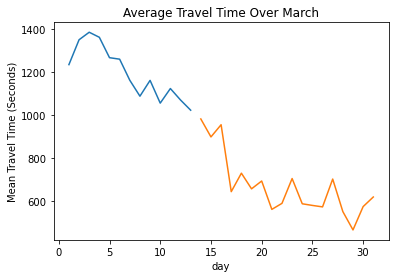

In [62]:
sns.lineplot(data=lineplotpre, x="day", y="Mean Travel Time (Seconds)")
sns.lineplot(data=lineplotpost, x="day", y="Mean Travel Time (Seconds)")
plt.title('Average Travel Time Over March');

In [63]:
merged = mergedmeans.reset_index().merge(tract_to_gps, left_on = 'Destination Movement ID',right_on = 'MOVEMENT_ID')

In [64]:
mapping = merged.sort_values('diff')[0:20]
mapping1 = merged.sort_values('diff', ascending = False)[0:20]

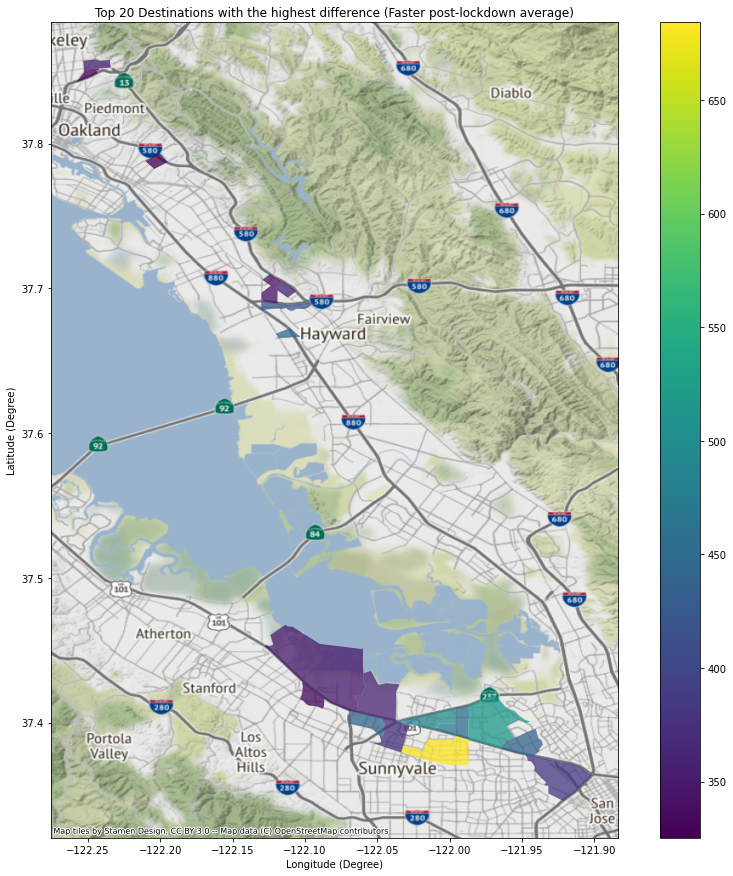

In [65]:
biggestdiff1 = gpd.GeoDataFrame(mapping1, geometry=mapping1['geometry'], crs="EPSG:4326")
plotter1 = biggestdiff1.plot(column='diff',figsize = (15,15),alpha = 0.75, legend = True)
cx.add_basemap(plotter1,crs = biggestdiff1.crs.to_string())
plt.title("Top 20 Destinations with the highest difference (Faster post-lockdown average)")
plt.xlabel('Longitude (Degree)')
plt.ylabel('Latitude (Degree)');

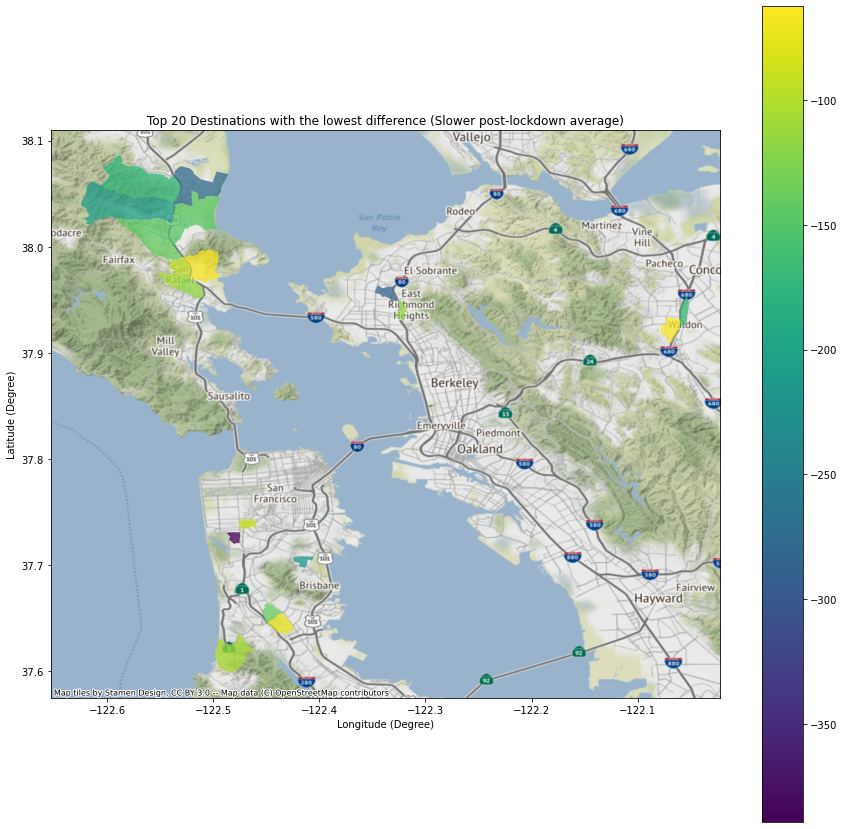

In [66]:
biggestdiff = gpd.GeoDataFrame(mapping, geometry=mapping['geometry'], crs="EPSG:4326")
plotter = biggestdiff.plot(column='diff',figsize = (15,15),alpha = 0.75, legend = True)
cx.add_basemap(plotter,crs = biggestdiff.crs.to_string())
plt.title("Top 20 Destinations with the lowest difference (Slower post-lockdown average)")
plt.xlabel('Longitude (Degree)')
plt.ylabel('Latitude (Degree)');

Here are two map graphs above, with the top one containing top 20 destination ids of the highest differences, while the bottom graph represents the top 20 destination ids with the lowest differences. Since we subtracted the pre-lockdown averages with the post-lockdown averages, we interpret positive differences as the pre-lockdown average of a particular destination id to be greater than the corresponding post-lockdown average.
From the graphs above, we can make a few observations. Destination IDs that were faster to get to post-lockdown were mainly south of San Francisco, near SunnyVale and San Jose. This might be caused by less traffic across freeways, mainly the 101 highway.However, destinations that were slower to get to post-lockdown tended to be areas north of San Francisco, crossing the gold gate bridge or the bay bridge.

Lets look at destination ids only within San Francisco. 

In [67]:
sfonly = merged[merged['DISPLAY_NAME'].str.contains("San Francisco")]
mappingsfonly = sfonly.sort_values('diff')
mapping1sfonly = sfonly.sort_values('diff', ascending = False)

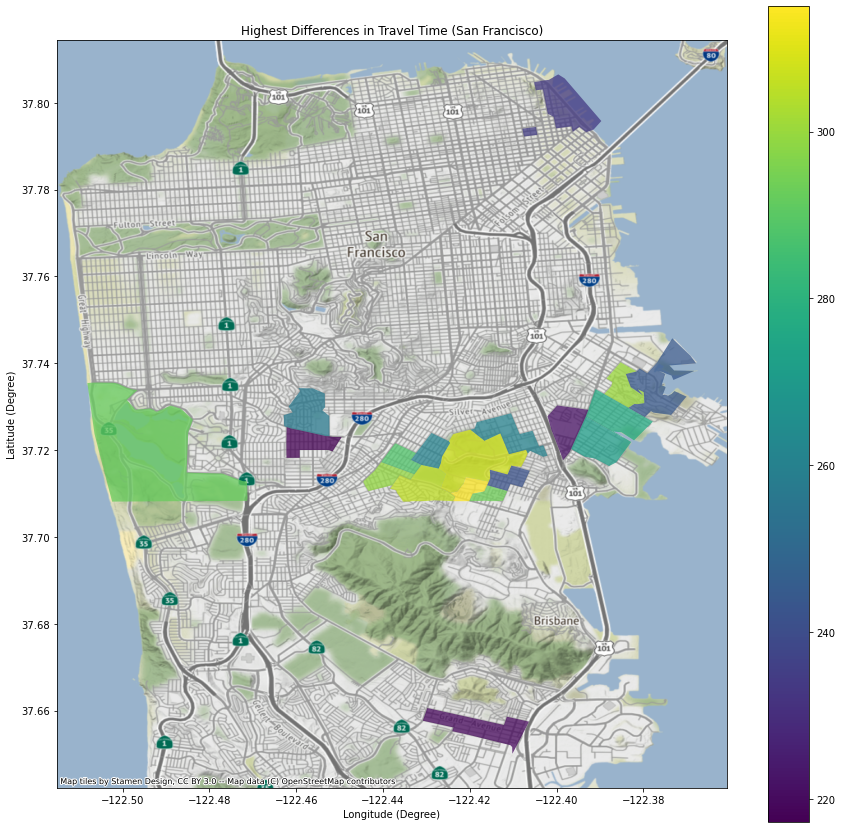

In [68]:
sf2 = gpd.GeoDataFrame(mapping1sfonly[0:20], geometry=mapping1sfonly[0:20]['geometry'], crs="EPSG:4326")
sf2plotter = sf2.plot(column='diff',figsize = (15,15),alpha = 0.75, legend = True)
cx.add_basemap(sf2plotter,crs = sf2.crs.to_string())
plt.title("Highest Differences in Travel Time (San Francisco)")
plt.xlabel('Longitude (Degree)')
plt.ylabel('Latitude (Degree)');

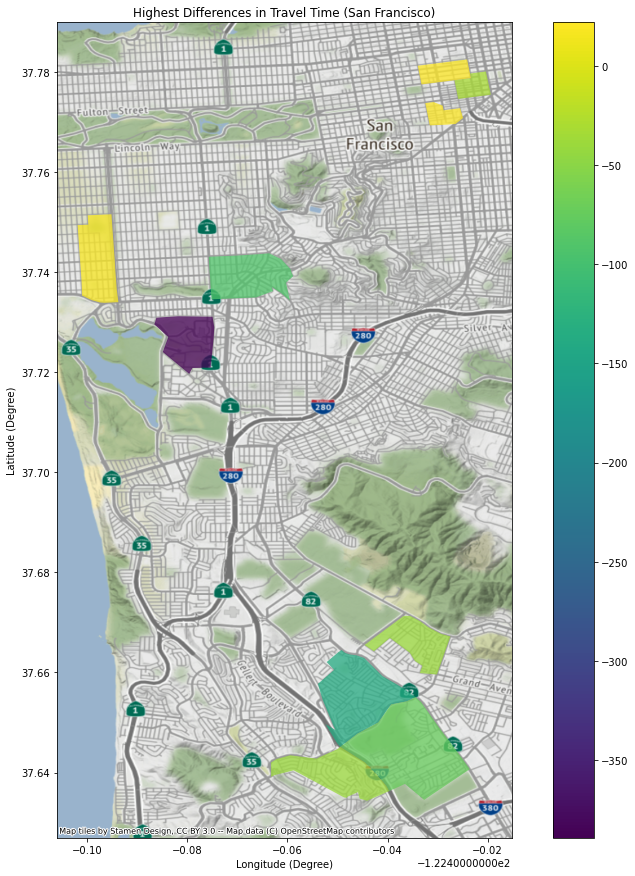

In [69]:
sf1 = gpd.GeoDataFrame(mappingsfonly[0:10], geometry=mappingsfonly[0:10]['geometry'], crs="EPSG:4326")
sfplotter = sf1.plot(column='diff',figsize = (15,15),alpha = 0.75, legend = True)
cx.add_basemap(sfplotter,crs = sf1.crs.to_string())
plt.title("Highest Differences in Travel Time (San Francisco)")
plt.xlabel('Longitude (Degree)')
plt.ylabel('Latitude (Degree)');

Similar to the ideas above, higher differences, faster post-lockdown average, while negative

# Step 4 - Guided Modeling: Predict traffic speed post-lockdown

In this step, you'll train a model to predict traffic speed. In particular, you'll learn how to provide implicit supervision and correction to your model, when you know there's been a distribution shift in its data, leading to a large gap between train and test sets. You'll follow the following outline:

- Build a model to predict daily traffic speed in San Francisco. Train and evaluate on *pre*-lockdown traffic speeds around the city.
- Evaluate your model on post-lockdown traffic speeds. Where is your model most mistaken, and why?
- Using this knowledge, how would you correct your model for a more accurate post-lockdown traffic predictor?


The technical term for a phenomenon like the lockdown, which caused major distributional shifts in the data, is *change point*. A large body of work studies "change point detection," but you'll be harder pressed to find a "handling change point" paper. 

## 4.a. Predict daily traffic speed on pre-lockdown data

For your model, you will predict daily traffic speed per census tract, given the previous $k=5$ daily traffic speeds for that census tract. In particular, say a matrix $A$ is $n \times d$, where $n$ is the number of census tracts and $d$ is the number of days. We define the following inputs and labels:

$$X_{(i,t)} = [A_{(i,t-5)}, A_{(i,t-4)}, A_{(i,t-3)}, A_{(i,t-2)}, A_{(i,t-1)}]$$
$$y_{(i,t)} = [A_{(i,t)}]$$

This just means that each sample $X_i$ includes speed averages from the previous 5 days for the $i$th census track.

### 4.a.i. Assemble dataset to predict daily traffic speed.

Below, we've included skeletons for the helper functions we defined, to complete the problem. We highly recommend following this skeleton code, else we cannot guarantee staff support for debugging your work.


**Hint**: What's wrong with collecting all samples, then randomly selecting some percentage to hold out? See the answer in the expandable below.

<details>
    <summary>[Click to expand] How to do train-validation split correctly, on time series</summary>
    
For a *time series* in particular, this random split would be cheating, because data within each day is highly correlated. Instead, you should hold out entire days from the dataset. In this case, you should hold out the last 2 days for your validation set.
</details>

<!--
BEGIN QUESTION
name: q4ai1
points: 1
-->

In [70]:
speeds_to_tract

osm_start_node_id  osm_end_node_id  day  speed_mph_mean  osm_node_id  \
0                26118026        259458979    1       64.478000     26118026   
1                26118026        259458979    2       62.868208     26118026   
2                26118026        259458979    3       62.211750     26118026   
3                26118026        259458979    4       62.192458     26118026   
4                26118026        259458979    5       61.913292     26118026   
...                   ...              ...  ...             ...          ...   
417634         4069109544        615120176   30       38.956000   4069109544   
417635         5448539901         65446993   16       25.627000   5448539901   
417636          302964668       4069109544   19       40.802000    302964668   
417637          302964668       4069109544   20       36.076000    302964668   
417638         5022068066        302964668   19       39.592000   5022068066   

         Latitude   Longitude  plus_latitude_idx  plus_longitude_idx  \
0       37.675280 -122.389194               3139              -10199   
1       37.675280 -122.389194               3139              -10199   
2       37.675280 -122.389194               3139              -10199   
3       37.675280 -122.389194               3139              -10199   
4       37.675280 -122.389194               3139              -10199   
...           ...         ...                ...                 ...   
417634  37.732039 -122.507126               3144              -10208   
417635  37.622476 -122.413763               3135              -10201   
417636  37.732418 -122.507206               3144              -10208   
417637  37.732418 -122.507206               3144              -10208   
417638  37.733635 -122.507100               3144              -10208   

                           geometry  index_right  MOVEMENT_ID  \
0       POINT (-122.38919 37.67528)         1729         1730   
1       POINT (-122.38919 37.67528)         1729         1730   
2       POINT (-122.38919 37.67528)         1729         1730   
3       POINT (-122.38919 37.67528)         1729         1730   
4       POINT (-122.38919 37.67528)         1729         1730   
...                             ...          ...          ...   
417634  POINT (-122.50713 37.73204)         1778         1779   
417635  POINT (-122.41376 37.62248)         1456         1457   
417636  POINT (-122.50721 37.73242)         1778         1779   
417637  POINT (-122.50721 37.73242)         1778         1779   
417638  POINT (-122.50710 37.73363)         1778         1779   

                                         DISPLAY_NAME  
0                               0 Park Lane, Brisbane  
1                               0 Park Lane, Brisbane  
2                               0 Park Lane, Brisbane  
3                               0 Park Lane, Brisbane  
4                               0 Park Lane, Brisbane  
...                                               ...  
417634  500 John Muir Drive, Lakeshore, San Francisco  
417635                  1500 Donner Avenue, San Bruno  
417636  500 John Muir Drive, Lakeshore, San Francisco  
417637  500 John Muir Drive, Lakeshore, San Francisco  
417638  500 John Muir Drive, Lakeshore, San Francisco  

[418848 rows x 13 columns]

In [71]:
def dataframe_to_time_series(df: pd.DataFrame):
    """Convert your dataframe into a 'time series'.
    
    :param df: the original dataframe, mapping speeds to census tracts.
        This dataframe should contain the `MOVEMENT_ID` (census tract id),
        `day`, and average speed for that day `speed_mph_mean`
    :return: a new dataframe that is formatted as n x d, where
        n is the number of samples (census tracts) and d is the number of
        dimensions (days). The values are the speeds.
    """
    grouped_mean_speed = df[['MOVEMENT_ID','day','speed_mph_mean']].groupby(['MOVEMENT_ID','day']).mean()
    return grouped_mean_speed.reset_index().pivot(index='MOVEMENT_ID',columns='day',values='speed_mph_mean')
time_series = dataframe_to_time_series(speeds_to_tract)
time_series_pre = time_series.iloc[:, list(range(13))]
time_series_pre

day                 1          2          3          4          5          6   \
MOVEMENT_ID                                                                     
9            16.196918  14.395121  13.868696  14.225414  14.312199  13.811991   
20           17.418045  15.460956  15.463297  15.419764  15.291956  15.227310   
21           15.141171  13.176998  13.781490  14.052113  14.078134  13.636357   
44           25.079544  23.492586  22.727711  22.274143  21.874703  23.082414   
78           16.174464  16.755496  16.039120  16.118401  15.665069  15.797723   
...                ...        ...        ...        ...        ...        ...   
2691               NaN        NaN        NaN        NaN  18.600000  17.787000   
2694         17.809761  16.725889  16.530783  16.446517  16.503053  16.652473   
2695         20.106061  20.228850  19.849135  20.145877  22.357605  19.250479   
2700         34.586890  31.372308  30.866382  31.000998  31.636377  30.213992   
2708         25.176235  24.725863  24.130040  24.287102  24.364056  25.090063   

day                 7          8          9          10         11         12  \
MOVEMENT_ID                                                                     
9            15.508637  16.210738  14.845320  14.711534  13.739901  14.391436   
20           17.088325  18.088862  16.178105  15.295494  14.637109  14.282602   
21           13.958269  14.642295  15.616215  14.850471  13.790100  14.573349   
44           22.875819  25.653848  23.501387  22.739869  23.756560  24.989269   
78           15.302616  19.284080  16.253357  16.131290  15.773117  16.091415   
...                ...        ...        ...        ...        ...        ...   
2691         23.473000        NaN  19.038000        NaN        NaN  22.107000   
2694         17.427329  18.057287  17.310272  16.998730  16.891788  17.008323   
2695         19.223717  19.471282  20.497077  20.401085  23.870537  20.215396   
2700         33.581884  35.443617  32.179867  32.951855  31.574525  32.172958   
2708         25.552157  26.296112  25.512403  24.886063  23.902599  25.262721   

day                 13  
MOVEMENT_ID             
9            13.955833  
20           14.437358  
21           15.177251  
44           23.176275  
78           16.208158  
...                ...  
2691               NaN  
2694         17.559142  
2695         20.343131  
2700         31.334364  
2708         24.450025  

[295 rows x 13 columns]

In [72]:
grader.check("q4ai1")

q4ai1 results: All test cases passed!

In [73]:
def time_series_to_numpy(df: pd.DataFrame, T: int, n_val: int):
    """Convert your 'time series' into train-validate splits, in numpy
    
    You can assume your dataframe contains a `day` column where days
    start from 1 and are consecutive.
    
    :param df: the dataframe formatted as n x d, where
        n is the number of samples (census tracts) and d is the number of
        dimensions (days). The values are the speeds.
    :param T: number of days to include in each training sample
    :param n_val: number of days to hold out for the validation set.
        Say we have 5 total days in our dataset, T=2, n_val=2. This means
        during training, we have samples that pull averages from days 1 and
        2 to predict day 3: x=(1, 2), y=(3,) For validation, we have samples
        like x=(2, 3), y=(4,) and x=(3, 4), y=(5,). This way, the model sees
        data from days 4 and 5 only during validation.
    :return: Set of 4 numpy arrays - X_train, y_train, X_val, y_val - where
        X_* arrays are (n, T) and y_* arrays are (n,).
    """
    X_train = np.array([])
    y_train = np.array([])
    for i in range(len(df.columns) - n_val - T):
        if i == 0:
            X_train = df.iloc[:, i:i+T].to_numpy()
            y_train = df.iloc[:, i+T:i+T+1].to_numpy()
        else:
            X_train = np.vstack((X_train, df.iloc[:, i:i+T].to_numpy()))
            y_train = np.append(y_train, df.iloc[:, i+T:i+T+1].to_numpy())

    X_val = np.array([])
    y_val = np.array([])
    for i in range(n_val):
        if i == 0:
            X_val = df.iloc[:, len(df.columns)-n_val+i-T:len(df.columns)-n_val+i]
            y_val = df.iloc[:, len(df.columns)-n_val+i]
        else:
            X_val = np.vstack((X_val, df.iloc[:, len(df.columns)-n_val+i-T:len(df.columns)-n_val+i]))
            y_val = np.append(y_val, df.iloc[:, len(df.columns)-n_val+i])
            
#     X_train = np.array(X_train)
#     y_train = np.array(y_train)
#     X_val = np.array(X_val)
#     y_val = np.array(y_val)
    
    #return X_val, y_val    
    return X_train, y_train, X_val, y_val

# 1 2 3 .. 15 <- 10 validation
# 15, 14,... 5
# 3, 4, .. 14
    
def remove_nans(X: np.array, y: np.array):
    """Remove all nans from the provided (X, y) pair.
    
    Note: A nan in X means that sample must be removed from *both X and y.
        Likewise, a nan in y means that sample must be removed from *both
        X and y.
    
    :param X: (n, T) array of model inputs
    :param y: (n,) array of labels
    :return: (X, y)
    """
    if not len(X):
        return X, y
    new_X = np.array([])
    new_Y = np.array([])
    
    for i in range(len(X)):
        if not np.isnan(np.sum(X[i])) and not np.isnan(y[i]):
            if len(new_X) == 0:
                new_X = X[i]
            else:
                new_X = np.vstack((new_X, X[i]))
            new_Y = np.append(new_Y, y[i])
    return new_X, new_Y
answer = time_series_to_numpy(time_series, 10, 2)
answer2 = remove_nans(answer[0], answer[1])
#answer2[0].shape

In [74]:
grader.check("q4ai2")

q4ai2 results: All test cases passed!

In [75]:
def time_series_to_dataset(time_series: pd.DataFrame, T: int, n_val: int):
    """Convert 'time series' dataframe to a numpy dataset.
    
    Uses utilites above `time_series_to_numpy` and `remove_nans`
    
    For description of arguments, see `time_series_to_numpy` docstring.
    """
    X_train, y_train, X_val, y_val = time_series_to_numpy(time_series, T, n_val)
    X_train, y_train = remove_nans(X_train, y_train)
    X_val, y_val = remove_nans(X_val, y_val)
    return X_train, y_train, X_val, y_val
X_train, y_train, X_val, y_val = time_series_to_dataset(time_series_pre, 5, 2)

In [76]:
grader.check("q4ai3")

q4ai3 results: All test cases passed!

In [77]:
(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

((1705, 5), (1705,), (562, 5), (562,))

<!-- BEGIN QUESTION -->

### 4.a.ii. Train and evaluate linear model on pre-lockdown data.

1. **Train a linear model that forecasts the next day's speed average** using your training dataset `X_train`, `y_train`. Specifically, predict $y_{(i,t)}$ from $X_{(i,t)}$, where
- $y_{(i,t)}$ is the daily speed average for day $t$ and census tract $i$
- $X_{(i,t)}$ is a vector of daily speed averages for days $t-5,t-4,t-3,t-2,t-1$ for census tract $i$
2. **Evaluate your model** on your validation dataset `X_val`, `y_val`.
3. **Make a scatter plot**, plotting predicted averages against ground truth averages. Note the perfect model would line up all points along the line $y=x$.

Our model is quantitatively and qualitatively pretty accurate at this point, training and evaluating on pre-lockdown data.

<!--
BEGIN QUESTION
name: q4aii1
points: 1
manual: True
-->

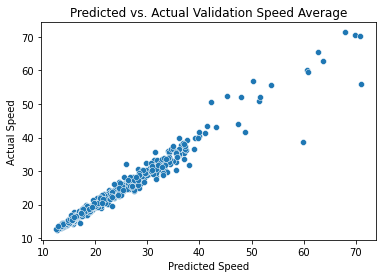

In [78]:
reg = LinearRegression().fit(X_train, y_train) # set to trained linear model
score = reg.score(X_val, y_val) # report r^2 score
# create the scatter plot below
y_pred = reg.predict(X_val)
sns.scatterplot(x=y_pred, y=y_val)
plt.title("Predicted vs. Actual Validation Speed Average")
plt.xlabel('Predicted Speed')
plt.ylabel('Actual Speed');

<!-- END QUESTION -->

<!--
BEGIN QUESTION
name: q4aii2
points: 1
-->

In [79]:
score

0.9639232922122069

In [80]:
grader.check("q4aii2")

q4aii2 results: All test cases passed!

## 4.b. Understand failures on post-lockdown data

Your dataset is distributed spatially and temporally. As a result, the most intuitive spaces to visualize your model error or performance along is both spatially and temporally. In this step, we focus on understanding *where* your model fails.

### 4.b.i. Evaluate on post-lockdown data

1. Using your previously trained linear regression model `reg`, **evaluate on post-lockdown data**, meaning daily speed averages on March 14, 2020. Evaluate on all census tracts.
2. **Make a scatter plot**, plotting predicted averages against ground truth averages. Note the perfect model would line up all points along the line $y=x$.

<!--
BEGIN QUESTION
name: q4bi1
points: 1
-->

In [81]:
time_series_x_pre = time_series.iloc[:, [8, 9, 10, 11, 12]].to_numpy() # get 'time series' dataframe for days 8, 10, 11, 12, 13
time_series_y_post = time_series.iloc[:, 13].to_numpy() # get 'time series' dataframe for 14th
x_pre_filtered, y_post_filtered = remove_nans(time_series_x_pre, time_series_y_post)
score_pre_14th = reg.score(x_pre_filtered, y_post_filtered)
score_pre_14th

0.9337122097376677

In [82]:
grader.check("q4bi1")

q4bi1 results: All test cases passed!

<!-- BEGIN QUESTION -->

Make scatter plot below.
<!--
BEGIN QUESTION
name: q4bi2
points: 1
manual: True
-->

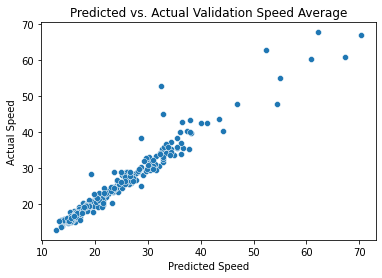

In [83]:
y_post_pred = reg.predict(x_pre_filtered)
sns.scatterplot(x=y_post_pred, y=y_post_filtered)
plt.title("Predicted vs. Actual Validation Speed Average")
plt.xlabel('Predicted Speed')
plt.ylabel('Actual Speed');

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### 4.b.ii. Report model performance temporally

1. **Make a line plot** showing performance of the original model throughout all of March 2020.
2. **Report the lowest point on the line plot**, reflecting the lowest model performance.
2. **Why is model performance the worst on the 17th?** Why does it begin to worsen on march 15th? And continue to worsen? Use what you know about covid measures on those dates. You may find this webpage useful: https://abc7news.com/timeline-of-coronavirus-us-covid-19-bay-area-sf/6047519/
3. **Is the dip in performance on the 9th foreshadowed** by any of our EDA?
4. **How does the model miraculously recover on its own?**
5. **Make a scatter plot**, plotting predicted averages against ground truth averages *for model predictions on March 17th*. Note the perfect model would line up all points along the line $y=x$. When compared against previous plots of this nature, this plot looks substantially worse, with points straying far from $y=x$.

**Note:** Answer questions 2-5 in the Markdown cell below. Q1 and Q6 are answered in the two code cells below.

<!--
BEGIN QUESTION
name: q4bii1
points: 3
manual: True
-->



- 2. The lowest point in terms of model score was on March 17th, where the r score was around 0.72

- 3. The model performance is the worst on the 17th because it was the day after the shelter in place order was issued (issued on the 16th), so perhaps many people were still figuring out work accomodations and how the pandemic would affect their jobs.

- 4. Looking at our plot in average speeds in March, the 9th was when speeds started to increase dramatically as Covid was starting to become more of a concern. 

- 5. Even though it was trained on the data from the pre-Covid lockdown, the model is still a linear combination of the previous 5 days, so this allows it to stabilize as more data becomes available. The main issue is that the model performs badly when sudden change occurs. 

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

Generate line plot.
<!--
BEGIN QUESTION
name: q4bii2
points: 1
manual: True
-->

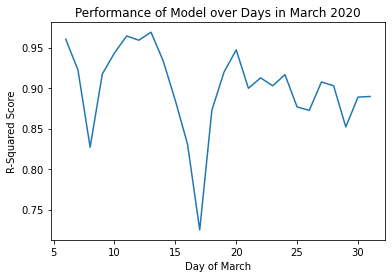

In [84]:
daily_scores = []
for i in range(len(time_series.columns)-5):
    daily_x = time_series.iloc[:, [i, i+1, i+2, i+3, i+4]].to_numpy() 
    daily_y = time_series.iloc[:, i+5].to_numpy() 
    daily_x, daily_y = remove_nans(daily_x, daily_y)
    daily_scores.append(reg.score(daily_x, daily_y))
sns.lineplot(x=np.arange(6, 31+1, 1), y=daily_scores)
plt.title('Performance of Model over Days in March 2020')
plt.xlabel('Day of March')
plt.ylabel('R-Squared Score');

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

Generate a scatter plot.
<!--
BEGIN QUESTION
name: q4bii3
points: 1
manual: True
-->

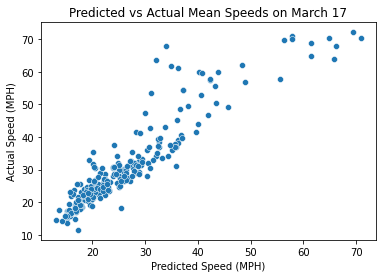

In [85]:
time_series_x_17 = time_series.iloc[:, [11, 12, 13, 14, 15]].to_numpy() # get 'time series' dataframe for days 12-15
time_series_y_17 = time_series.iloc[:, 16].to_numpy() # get 'time series' dataframe for 17th
time_series_x_17, time_series_y_17 = remove_nans(time_series_x_17, time_series_y_17)
y_pred_17 = reg.predict(time_series_x_17)
sns.scatterplot(x=y_pred_17, y=time_series_y_17)
plt.title('Predicted vs Actual Mean Speeds on March 17')
plt.xlabel('Predicted Speed (MPH)')
plt.ylabel('Actual Speed (MPH)');

<!-- END QUESTION -->



## 4.c. "Fix" model on post-lockdown data

Per this survey https://pure.tue.nl/ws/files/3488790/740215.pdf, there are 4 categories of fixes for change points:
- Forgetting mechanisms
- Explicit change detection
- Ensemble techniques
- Context-aware approaches

In this part, we'll combine insights in model errors with previous EDA insights to produce a fix.

<!-- BEGIN QUESTION -->

### 4.c.i. Learn delta off of a moving bias

According to our previous work in EDA, the average speed shoots upwards sharply. As a result, our trick to learn delta the around the average and to naively assume that the average of day $t$ is the average for day $t+1$. We will do this in 4 steps:

1. **Create a dataset for your delta model**.
2. **Train your delta model** on pre-lockdown data.
3. **Evaluate your model on pre-lockdown data**, to ensure that the model has learned to a satisfactory degree, in the nominal case. Remember the naive model achieved 0.97 r^2 on pre-lockdown data.
4. **Evaluate your model on the 17th**, to compare against the naive model also evaluated on that day. Notice that your r^2 score has improved by 10%+. Why is your delta model so effective for the 17th?
5. **Evaluate your model on the 14th**, to compare against the naive model also evaluated on that day. Notice that your r^2 score is now complete garbage. Why is your delta so ineffective for the 14th?

**Hint**: As you build your datasets, always check to make sure you're using the right days! It's easy to have a one-off error that throws off your results.

Write your written questions in the next cell, then write the code in the following cells.

<!--
BEGIN QUESTION
name: q4ci1
points: 2
manual: True
-->

4. The delta model is effective for the 17th because it is able to predict changes around the average speed. Since the 17th was a few days after lockdown was implemented, it was able to adjust based on the previous days. It also assumes that the average for a day t is the average for day t+1, so in the case of the 17th, it relied on the average speed of the 16th which already reflected the lockdown's effects.

<!-- END QUESTION -->

<!--
BEGIN QUESTION
name: q4ci2
points: 1
-->

In [86]:
time_series_delta_full = time_series - speeds_daily
time_series_delta = time_series_delta_full.iloc[:,:13] # subtract daily average from pre-lockdown 'time series' dataframe `time_series_pre`
time_series_delta

day                 1         2         3         4         5         6   \
MOVEMENT_ID                                                                
9            -7.436210 -7.929735 -7.957726 -7.706332 -7.673488 -8.288859   
20           -6.215082 -6.863900 -6.363125 -6.511982 -6.693731 -6.873540   
21           -8.491956 -9.147858 -8.044932 -7.879632 -7.907553 -8.464493   
44            1.446417  1.167730  0.901289  0.342397 -0.110985  0.981564   
78           -7.458664 -5.569360 -5.787301 -5.813345 -6.320619 -6.303126   
...                ...       ...       ...       ...       ...       ...   
2691               NaN       NaN       NaN       NaN -3.385687 -4.313850   
2694         -5.823366 -5.598968 -5.295639 -5.485229 -5.482634 -5.448377   
2695         -3.527067 -2.096006 -1.977287 -1.785869  0.371917 -2.850371   
2700         10.953762  9.047451  9.039961  9.069252  9.650690  8.113142   
2708          1.543108  2.401007  2.303618  2.355356  2.378369  2.989213   

day                 7          8         9          10        11        12  \
MOVEMENT_ID                                                                  
9            -7.342673  -7.838718 -8.163539  -7.950124 -9.037052 -8.687048   
20           -5.762984  -5.960594 -6.830754  -7.366163 -8.139844 -8.795882   
21           -8.893040  -9.407162 -7.392644  -7.811186 -8.986853 -8.505135   
44            0.024509   1.604391  0.492527   0.078211  0.979607  1.910786   
78           -7.548693  -4.765377 -6.755502  -6.530367 -7.003837 -6.987069   
...                ...        ...       ...        ...       ...       ...   
2691          0.621691        NaN -3.970859        NaN       NaN -0.971484   
2694         -5.423980  -5.992169 -5.698587  -5.662927 -5.885166 -6.070161   
2695         -3.627592  -4.578175 -2.511783  -2.260573  1.093583 -2.863087   
2700         10.730575  11.394160  9.171008  10.290198  8.797572  9.094474   
2708          2.700848   2.246655  2.503544   2.224406  1.125645  2.184237   

day                13  
MOVEMENT_ID            
9           -9.364599  
20          -8.883074  
21          -8.143181  
44          -0.144157  
78          -7.112274  
...               ...  
2691              NaN  
2694        -5.761289  
2695        -2.977301  
2700         8.013932  
2708         1.129593  

[295 rows x 13 columns]

In [87]:
grader.check("q4ci2")

q4ci2 results: All test cases passed!

In [88]:
X_delta_train, y_delta_train, X_delta_val, y_delta_val = time_series_to_dataset(time_series_delta, 5, 2)

X_delta_train, y_delta_train = remove_nans(X_delta_train, y_delta_train)
X_delta_val, y_delta_val = remove_nans(X_delta_val, y_delta_val)
reg_delta = LinearRegression().fit(X_delta_train, y_delta_train)
res_4ci3 = reg_delta.score(X_delta_val, y_delta_val) # learning delta as easy as learning original dataset!
res_4ci3

0.9645254590172871

In [89]:
grader.check("q4ci3")

q4ci3 results: All test cases passed!

In [90]:
time_series_x_pre_delta = time_series_delta_full.iloc[:, [11, 12, 13, 14, 15]].to_numpy() # get 'time series' dataframe for days 8, 10, 11, 12, 13
time_series_y_post_delta = time_series_delta_full.iloc[:, 16].to_numpy() # get 'time series' dataframe for 14th
time_series_x_pre_delta, time_series_y_post_delta = remove_nans(time_series_x_pre_delta, time_series_y_post_delta)
score_pre_14th_delta = reg.score(time_series_x_pre_delta, time_series_y_post_delta)
res_4ci4 = score_pre_14th_delta
res_4ci4

0.831478931420164

In [91]:
grader.check("q4ci4")

q4ci4 results:
    q4ci4 - 1 result:
        Trying:
            np.isclose(res_4ci4, 0.8616633417528182, rtol=1e-4, atol=1e-4)
        Expecting:
            True
        **********************************************************************
        Line 1, in q4ci4 0
        Failed example:
            np.isclose(res_4ci4, 0.8616633417528182, rtol=1e-4, atol=1e-4)
        Expected:
            True
        Got:
            False

In [92]:
res_4ci5 = ...

In [93]:
grader.check("q4ci5")

q4ci5 results:
    q4ci5 - 1 result:
        Trying:
            np.isclose(res_4ci5, 0.11611253470677951, rtol=1e-4, atol=1e-4)
        Expecting:
            True
        **********************************************************************
        Line 1, in q4ci5 0
        Failed example:
            np.isclose(res_4ci5, 0.11611253470677951, rtol=1e-4, atol=1e-4)
        Exception raised:
            Traceback (most recent call last):
              File "/opt/conda/lib/python3.9/doctest.py", line 1336, in __run
                exec(compile(example.source, filename, "single",
              File "<doctest q4ci5 0[0]>", line 1, in <module>
                np.isclose(res_4ci5, 0.11611253470677951, rtol=1e-4, atol=1e-4)
              File "<__array_function__ internals>", line 5, in isclose
              File "/opt/conda/lib/python3.9/site-packages/numpy/core/numeric.py", line 2355, in isclose
                xfin = isfinite(x)
            TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

### 4.c.ii. Does it "solve itself"? Does the pre-lockdown model predict, after the change point?

Had we ignored the problem, would we have been okay? The temporal plot above showing performance over time suggests a partial recovery. **Evaluate the original, naive model on all post-lockdown data** to see. If your final r^2 score does not match the autograder's:
- Double check you have selected daily average speeds for the right days, by printing your dataframe.
- Double check you're using the right model (a brand new trained model)
- Check you're using `T=5, n_val=2`

<!--
BEGIN QUESTION
name: q4cii
points: 1
-->

In [94]:
post_time_series_df = time_series.iloc[:, 13:]
X_train_post, y_train_post, X_val_post, y_val_post = time_series_to_dataset(post_time_series_df, 5, 0)
score_og_post = reg.score(X_train_post, y_train_post)
score_og_post

0.9014738674628208

In [95]:
grader.check("q4cii")

q4cii results: All test cases passed!

### 4.c.iii. Naively retrain model with post-lockdown data

Can we use the same tactics--that we used to train the original model on pre-lockdown data--to train on the post-lockdown data? **Retrain a linear model and evaluate on post-lockdown data only**. You should construct a new dataset using `time_series_to_dataset` using only time series from March 14 to March 31. If your final r^2 score does not match the autograder's:
- Double check you have selected daily average speeds for the right days, by printing your dataframe.
- Double check you're using the right model (a brand new trained model)
- Check you're using `T=5, n_val=2`

<!--
BEGIN QUESTION
name: q4ciii
points: 1
-->

In [96]:
X_train_post, y_train_post, X_val_post, y_val_post = time_series_to_dataset(post_time_series_df, 5, 2)
reg_post = LinearRegression().fit(X_train_post, y_train_post)

score_post = reg_post.score(X_val_post, y_val_post)
score_post

0.8993687576351703

In [97]:
grader.check("q4ciii")

q4ciii results: All test cases passed!

### 4.c.iv. What if you just ignore the change point?

Turns out, this is no good. Even acknowledging the change point and training *either* before *or* after is better. Being ignorant and training on *both* is the worst option, producing a lower r^2.

<!--
BEGIN QUESTION
name: q4civ
points: 1
-->

In [98]:
X_train_full, y_train_full, X_val_full, y_val_full = time_series_to_dataset(time_series, 5, 5)
reg_full = LinearRegression().fit(X_train_full, y_train_full)
res_4civ = reg_full.score( X_val_full, y_val_full)
res_4civ

0.8843433608623491

In [99]:
grader.check("q4civ")

q4civ results: All test cases passed!

# Step 5 - Open-Ended Modeling: Predicting travel time post-lockdown

*This* is the real deal and ultimately what Uber cares about. Traffic speeds is a proxy task, but the bottom line and moneymaking machine relies on this travel time estimation. Focus on designing experiments instead of focusing on experimental, quantitative results. Your experiments are successful if they inform a decision, even despite a lower-performing model.

## Question 5a

Train a baseline model of your choice using any supervised learning approach we have studied; you are not limited to a linear model.


**Example**

Given the data for this question, you could build a model to predict travel time from Cheesecake Factory to UC Berkeley.

In [100]:
from sklearn.model_selection import train_test_split

In [101]:
scoretracker = []
y = times_to_tract["Mean Travel Time (Seconds)"]
X = times_to_tract[["Destination Movement ID", "day"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
basemodel = LinearRegression().fit(X_train, y_train)
scoretracker.append(basemodel.score(X_test, y_test))
basemodel.score(X_test, y_test)

0.16824539446380915

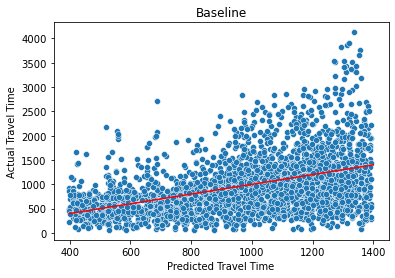

In [102]:
sns.scatterplot(x=basemodel.predict(X_test).flatten(), y=y_test.to_numpy().flatten())
plt.plot([400, 1400], [400, 1400],color = 'red')

plt.title("Baseline")
plt.xlabel('Predicted Travel Time')
plt.ylabel('Actual Travel Time');


## Question 5b

Improve on your baseline model. Specify the model you designed and its input features. Justify why you chose these features and their relevance to your model's predictions.

**Example**

Here are potential questions to consider for this part: How does the other variant of your travel times dataset, aggregated across time but reported for all routes, useful?  What additional data from the Uber Movement website can you export to better your model?

In question 5a, we trained a very simple model to serve as a baseline. In question 5b, we decided to add more features such as the distance between our destination and Hayes Valley, and the average speed at that location and day based on the speeds dataset we were provided. We also changed the destination movement ID from being treated as a quantitative variable to a categorical variable by using PCA and dividing up the locations into separate regions. Adding all these factors improved our model's accuracy significantly from 18% to 80% approximately.

In [103]:
speeds_to_tract_filtered_avg = speeds_to_tract[["Latitude", "Longitude", "MOVEMENT_ID"]].groupby("MOVEMENT_ID").mean()
times_to_tract_joined = times_to_tract.merge(speeds_to_tract_filtered_avg, left_on="Destination Movement ID", right_on="MOVEMENT_ID", how="inner")
times_to_tract_joined.head()

Origin Movement ID                            Origin Display Name  \
0                1277  300 Hayes Street, Civic Center, San Francisco   
1                1277  300 Hayes Street, Civic Center, San Francisco   
2                1277  300 Hayes Street, Civic Center, San Francisco   
3                1277  300 Hayes Street, Civic Center, San Francisco   
4                1277  300 Hayes Street, Civic Center, San Francisco   

   Destination Movement ID                    Destination Display Name  \
0                        9  500 Hyde Street, Tenderloin, San Francisco   
1                        9  500 Hyde Street, Tenderloin, San Francisco   
2                        9  500 Hyde Street, Tenderloin, San Francisco   
3                        9  500 Hyde Street, Tenderloin, San Francisco   
4                        9  500 Hyde Street, Tenderloin, San Francisco   

                                      Date Range  Mean Travel Time (Seconds)  \
0  3/1/2020 - 3/1/2020, Every day, Daily Average                         322   
1  3/2/2020 - 3/2/2020, Every day, Daily Average                         355   
2  3/3/2020 - 3/3/2020, Every day, Daily Average                         369   
3  3/4/2020 - 3/4/2020, Every day, Daily Average                         369   
4  3/5/2020 - 3/5/2020, Every day, Daily Average                         376   

   Range - Lower Bound Travel Time (Seconds)  \
0                                        211   
1                                        220   
2                                        233   
3                                        230   
4                                        246   

   Range - Upper Bound Travel Time (Seconds)  day   Latitude   Longitude  
0                                        489    1  37.785509 -122.415657  
1                                        570    2  37.785509 -122.415657  
2                                        583    3  37.785509 -122.415657  
3                                        590    4  37.785509 -122.415657  
4                                        574    5  37.785509 -122.415657

In [104]:
from geopy import distance
def hayes_valley_distance(lat1, long1):
    return distance.distance((lat1, long1), (37.776575, -122.422342)).miles

times_to_tract_joined["distance"] = times_to_tract_joined.apply(lambda x: hayes_valley_distance(x.Latitude, x.Longitude), axis=1)

In [105]:
grouped_speeds = speeds_to_tract[["day", "MOVEMENT_ID", "speed_mph_mean"]].groupby(["day", "MOVEMENT_ID"]).mean().reset_index()
grouped_speeds

day  MOVEMENT_ID  speed_mph_mean
0       1            9       16.196918
1       1           20       17.418045
2       1           21       15.141171
3       1           44       25.079544
4       1           78       16.174464
...   ...          ...             ...
8036   31         2660       64.414000
8037   31         2673       36.297986
8038   31         2694       24.056357
8039   31         2695       19.959500
8040   31         2700       48.398038

[8041 rows x 3 columns]

In [106]:
times_to_tract_joined2 = times_to_tract_joined.merge(grouped_speeds, left_on=["day", "Destination Movement ID"], right_on=["day", "MOVEMENT_ID"], how="inner")
day_dummies = pd.get_dummies(times_to_tract_joined2["day"])

In [107]:
model2X = times_to_tract_joined2[["Latitude", "Longitude", "speed_mph_mean"]]
model2y = times_to_tract_joined2[["Mean Travel Time (Seconds)"]]
model2X = pd.concat([model2X,day_dummies],axis = 1)
X_train, X_test, y_train, y_test = train_test_split(model2X, model2y, test_size=0.25)
model2 = LinearRegression().fit(X_train, y_train)
scoretracker.append(model2.score(X_test, y_test))
model2.score(X_test, y_test)

0.5021971040262654

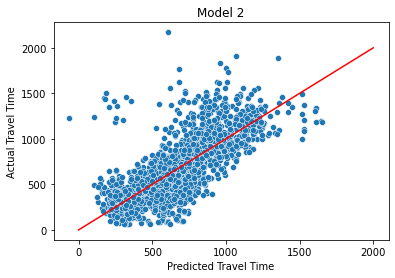

In [108]:
sns.scatterplot(x=model2.predict(X_test).flatten(), y=y_test.to_numpy().flatten())
plt.plot([0, 2000], [0, 2000],color = 'red')

plt.title("Model 2")
plt.xlabel('Predicted Travel Time')
plt.ylabel('Actual Travel Time');


In [109]:
model3X = times_to_tract_joined2[["Latitude", "Longitude", "speed_mph_mean","distance"]]
model3y = times_to_tract_joined2[["Mean Travel Time (Seconds)"]]
model3X = pd.concat([model3X,day_dummies],axis = 1)
X_train, X_test, y_train, y_test = train_test_split(model3X, model3y, test_size=0.25)
model3 = LinearRegression().fit(X_train, y_train)
scoretracker.append(model3.score(X_test, y_test))
model3.score(X_test, y_test)

0.7876230929009034

In [110]:
D = times_to_tract_joined2[['Longitude','Latitude']]
pca_means = D.mean()
X = D - pca_means
u, s, vt = np.linalg.svd(X, full_matrices=False)

def add_region(t):
    """Add a region column to t based on vt above."""
    D = t[['Longitude','Latitude']]
    assert D.shape[0] == t.shape[0], 'You set D using the incorrect table'
    # Always use the same data transformation used to compute vt
    X = D - pca_means 
    first_pc = (X@vt.T)[0]
    t.loc[:,'region'] = pd.qcut(first_pc, 10, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
add_region(times_to_tract_joined2)

In [111]:

region_dummies = pd.get_dummies(times_to_tract_joined2["region"])
model4X = pd.concat([day_dummies, region_dummies, times_to_tract_joined2[["distance", "Latitude", "Longitude", "speed_mph_mean"]]], axis=1)
model4y = times_to_tract_joined2["Mean Travel Time (Seconds)"]
X_train, X_test, y_train, y_test = train_test_split(model4X, model4y, test_size=0.25)
model4 = LinearRegression().fit(X_train, y_train)
scoretracker.append(model4.score(X_test, y_test))
model4.score(X_test, y_test)

0.8247137819963022

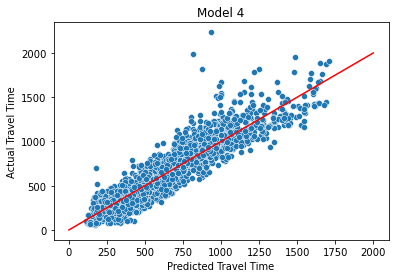

In [112]:
sns.scatterplot(x=model4.predict(X_test).flatten(), y=y_test.to_numpy().flatten())
plt.title("Model 4")
plt.xlabel('Predicted Travel Time')
plt.ylabel('Actual Travel Time');
plt.plot([0, 2000], [0, 2000],color = 'red')

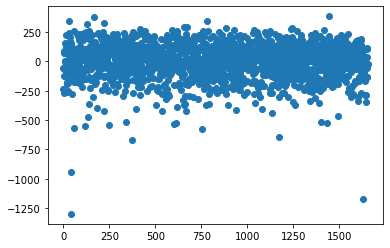

In [113]:
plt.scatter(np.arange(len(model4.predict(X_test) - y_test)),model4.predict(X_test) - y_test)

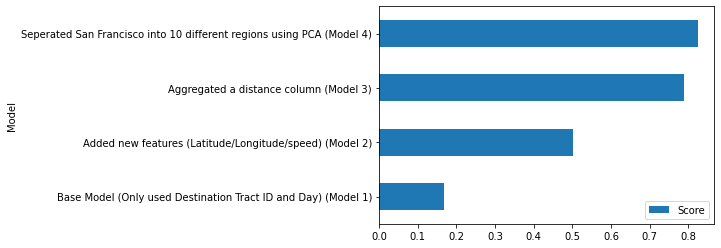

In [114]:
models = ['Base Model (Only used Destination Tract ID and Day) (Model 1)', 'Added new features (Latitude/Longitude/speed) (Model 2)', 'Aggregated a distance column (Model 3)','Seperated San Francisco into 10 different regions using PCA (Model 4)']
pd.DataFrame.from_dict({
    'Model': models,
    'Score': scoretracker
}).set_index('Model').plot(kind='barh');

## Question 5c

Explore other modeling aspects and/or temporal information. You are free to relate this to your hypothesis or not. Please expand into multiple parts that logically separate and break down your modeling work!

**Example**

For example, explore change across time, before and after the lockdown: (a) train and evaluate on *pre*-lockdown traffic travel times for that route; and (b) evaluate your model on *post*-lockdown traffic patterns.
How would you correct your model for a more accurate post-lockdown traffic predictor? *The above is just a suggestion. You may pick any topic you find interesting.*

### Adding Corporate Office Data

We compiled the latitude and longitude of some of the largest employers and their office locations in the Bay Area in the dataset shown below.

In [115]:
offices = pd.read_csv("./data/office_locations.csv")

We wrote this function to classify whether a latitude/longitude point is within a certain radius of any office in our dataset

In [116]:
def is_near_office(lat1, long1, threshold):
    for index, row in offices.iterrows():
        office_dist = distance.distance((lat1, long1), (row['Latitude'], row['Longitude'])).miles
        if office_dist < threshold:
            return 1
    return 0

In [117]:
times_to_tract_joined2["near_office"] = times_to_tract_joined2.apply(lambda x: is_near_office(x.Latitude, x.Longitude, 1), axis=1)

In [118]:
#training on all the days

day_dummies = pd.get_dummies(times_to_tract_joined2["day"])
region_dummies = pd.get_dummies(times_to_tract_joined2["region"])
X = pd.concat([day_dummies, region_dummies, times_to_tract_joined2[["distance", "Latitude", "Longitude", "speed_mph_mean", "near_office"]]], axis=1)
y = times_to_tract_joined2["Mean Travel Time (Seconds)"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
model_all = LinearRegression().fit(X_train, y_train)
print(model_all.score(X_test, y_test))
print("near_office coefficient: ", model_all.coef_[-1])

0.8402127545907507
near_office coefficient:  -85.29535670770565


### Training Models Pre and Post Lockdown - Does Separating by Day Improve Model Performance?

In [119]:
ttj2_pre = times_to_tract_joined2[times_to_tract_joined2["day"]<=13]
ttj2_post = times_to_tract_joined2[times_to_tract_joined2["day"]>13]

Pre-Lockdown:

In [120]:
day_dummies = pd.get_dummies(ttj2_pre["day"])
region_dummies = pd.get_dummies(ttj2_pre["region"])
X = pd.concat([day_dummies, region_dummies, ttj2_pre[["distance", "Latitude", "Longitude", "speed_mph_mean", "near_office"]]], axis=1)
y = ttj2_pre["Mean Travel Time (Seconds)"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
model_pre = LinearRegression().fit(X_train, y_train)
print(model_pre.score(X_test, y_test))
print("near_office coefficient: ", model_pre.coef_[-1])

0.807489684646753
near_office coefficient:  -135.99772521480918


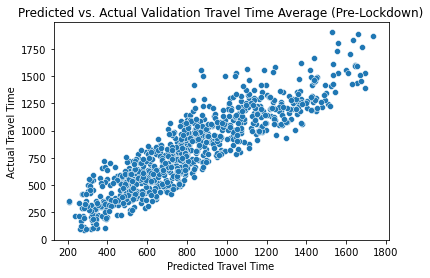

In [121]:
y_pre_pred = model_pre.predict(X_test)
sns.scatterplot(x=y_pre_pred, y=y_test)
plt.title("Predicted vs. Actual Validation Travel Time Average (Pre-Lockdown)")
plt.xlabel('Predicted Travel Time')
plt.ylabel('Actual Travel Time');

Post-Lockdown:

In [122]:
day_dummies = pd.get_dummies(ttj2_post["day"])
region_dummies = pd.get_dummies(ttj2_post["region"])
X = pd.concat([day_dummies, region_dummies, ttj2_post[["distance", "Latitude", "Longitude", "speed_mph_mean", "near_office"]]], axis=1)
y = ttj2_post["Mean Travel Time (Seconds)"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

model_post = LinearRegression().fit(X_train, y_train)
print(model_post.score(X_test, y_test))
print("near_office coefficient: ", model_post.coef_[-1])

0.8150946794792787
near_office coefficient:  -60.23854873511756


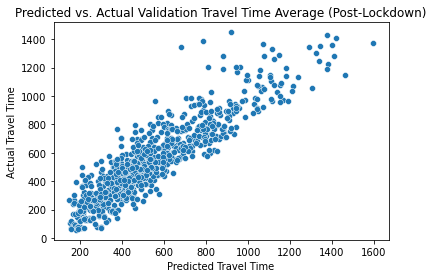

In [123]:
y_post_pred = model_post.predict(X_test)
sns.scatterplot(x=y_post_pred, y=y_test)
plt.title("Predicted vs. Actual Validation Travel Time Average (Post-Lockdown)")
plt.xlabel('Predicted Travel Time')
plt.ylabel('Actual Travel Time');

It looks like when separating the model into pre and post lockdown, we see a change in our near_office coefficient. Based on the values displayed above, the coefficient actually increases in value after the lockdown, which in this case since we are predicting travel time means that being near an office after the lockdown increased travel times. This is an interesting finding and was definitely not what we expected before doing this analysis.

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [124]:
grader.check_all()

q1a results: All test cases passed!

q1bi results: All test cases passed!

q1bii results: All test cases passed!

q1biii results: All test cases passed!

q1biv results: All test cases passed!

q1bv3 results: All test cases passed!

q1ci results: All test cases passed!

q1cii results: All test cases passed!

q1ciii results: All test cases passed!

q1civ3 results: All test cases passed!

q2ai2 results: All test cases passed!

q2ai3 results: All test cases passed!

q2ai4 results: All test cases passed!

q2aii2 results: All test cases passed!

q2aiii results: All test cases passed!

q2aiv3 results: All test cases passed!

q2av2 results: All test cases passed!

q4ai1 results: All test cases passed!

q4ai2 results: All test cases passed!

q4ai3 results:
    q4ai3 - 1 result:
        Trying:
            X_train.shape == (1705, 5)
        Expecting:
            True
        **********************************************************************
        Line 1, in q4ai3 0
        Failed example:

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [125]:
# Save your notebook first, then run this cell to export your submission.
grader.export()